In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Rectangle, Circle
from matplotlib.cm import ScalarMappable
from scipy.stats import chi2
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

GRADIENTE RADIAL TODO JUNTO

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/3046386690.py:17: SyntaxWarning: invalid escape sequence '\o'
  'mass': '$log(M_*)[M_{\odot}]$',
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/3046386690.py:69: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[ 4.03841358e-05 -1.85152018e-04]
 [-1.85152018e-04  1.03397464e-03]]
Pendiente: 0.0116 ± 0.0064
Intercepto:          8.0830
Chi-cuadrado:        1.94
Chi-cuadrado red.:   0.11
Grados de libertad:  17
p-valor del ajuste:  1.000


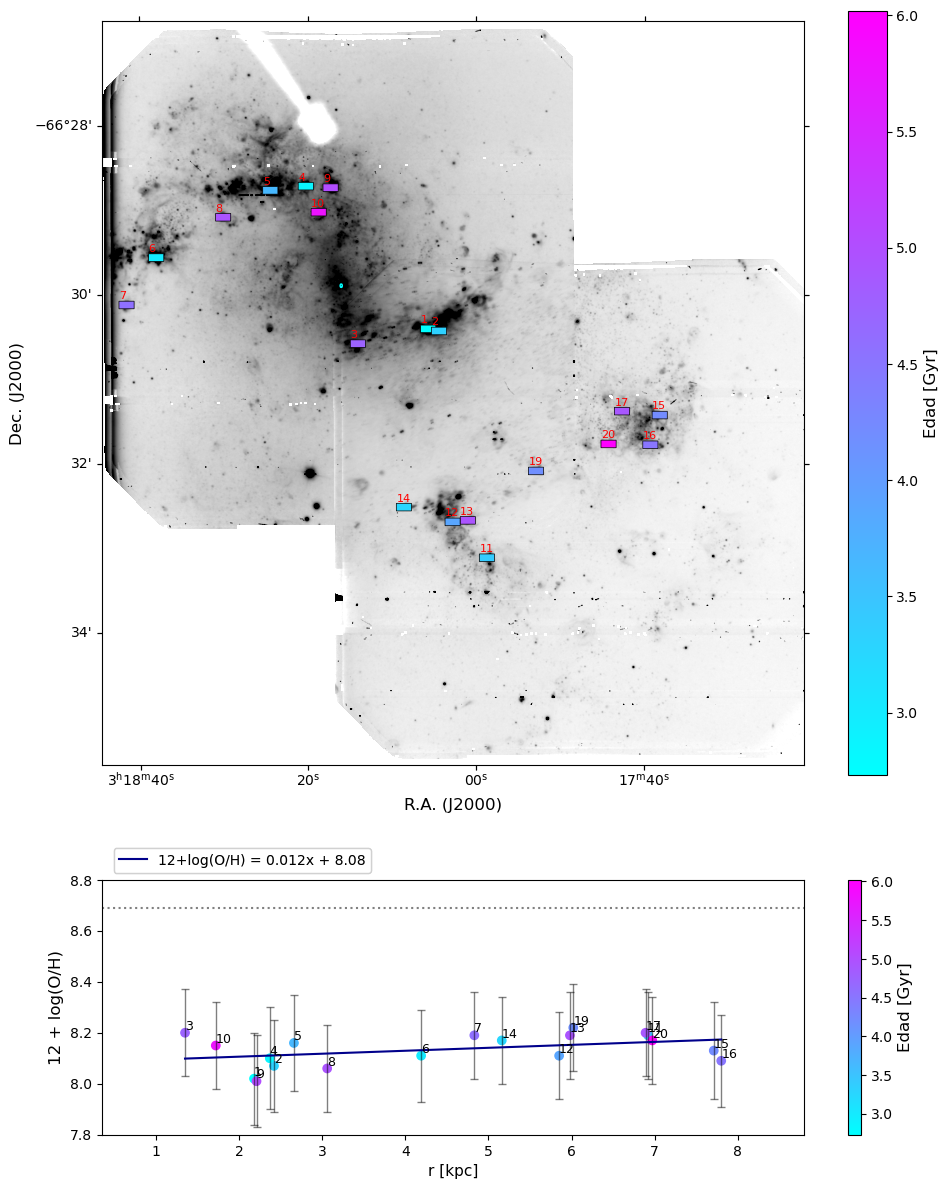

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Rectangle, Circle
from matplotlib.cm import ScalarMappable
from scipy.stats import chi2
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

# Parámetro para las colorbars
color_param = 'age'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Gyr]',
    'n_e': 'n$_e$ [cm$^{-3}$]'
}

# Cargar datos
df_gradient = pd.read_csv('gradiente_scarano_ne_masa_edad_newnumber_ne10.csv', delimiter=',')
df_slits = pd.read_csv('output_scarano.csv')
#df_signed = pd.read_csv('signed_distances.csv', delimiter=',')
#df_gradient = pd.merge(df_gradient, df_signed, on='ID')

# Definir grupos
#group_left_galaxy = df_gradient[df_gradient['signed_distance_kpc'] < 0]
#group_right_galaxy = df_gradient[df_gradient['signed_distance_kpc'] >= 0]
#group_clouds = df_gradient[df_gradient['ID'].isin(range(11, 20))]

# Verificar número de puntos en cada grupo
#print(f"Number of points in group_left: {len(group_left_galaxy)}")
#print(f"Number of points in group_right_galaxy: {len(group_right_galaxy)}")
#print(f"Number of points in group_clouds: {len(group_clouds)}")

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool

# Parámetros de los slits
width_deg = 0.0075
height_deg = 0.0015
ra_center = 49.566875
dec_center = -66.498250
circle_radius_deg = 0.0002

# Cargar imágenes FITS
hdul1 = fits.open('../../../reduccion/mrgS20190730S0157_add.fits')
data1 = hdul1['SCI'].data
wcs1 = WCS(hdul1['SCI'].header)

hdul2 = fits.open('../../../reduccion/mrgS20190730S0160_add.fits')
data2 = hdul2['SCI'].data
wcs2 = WCS(hdul2['SCI'].header)

# Enmascarar valores de bordes
data1 = np.where(data1 == 593.67285, np.nan, data1)
data2 = np.where(data2 == 380.0607, np.nan, data2)

# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)

# Configurar figura
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['r_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado
weights = 1 / sigma_y
coeffs, cov = np.polyfit(x, y, deg=1, w=weights, cov=True)
m, b = coeffs
m_err = np.sqrt(cov[0,0])
b_err = np.sqrt(cov[1,1])
y_pred = m * x + b
chi_squared = np.sum((y - y_pred)**2 / sigma_y**2)
dof = len(x) - 2
reduced_chi_squared = chi_squared / dof if dof > 0 else np.nan
p_value = 1 - chi2.cdf(chi_squared, dof)

# Ajuste lineal ponderado para Galaxia (Derecho)
# if len(group_right_galaxy) > 1:
#     x2 = group_right_galaxy['signed_distance_kpc'].values
#     y2 = group_right_galaxy['12_LOG_OH_N2'].values
#     sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
#     weights2 = 1 / sigma_y2
#     coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
#     m2, b2 = coeffs2
#     m2_err = np.sqrt(cov2[0,0])
#     b2_err = np.sqrt(cov2[1,1])
#     y_pred2 = m2 * x2 + b2
#     chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
#     dof2 = len(x2) - 2
#     reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
# else:
#     m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
# if len(group_clouds) > 1:
#     x3 = group_clouds['signed_distance_kpc'].values
#     y3 = group_clouds['12_LOG_OH_N2'].values
#     sigma_y3 = group_clouds['12_LOG_OH_N2_ERR'].values
#     weights3 = 1 / sigma_y3**2
#     m3, b3 = np.polyfit(x3, y3, deg=1, w=weights3)
#     y_pred3 = m3 * x3 + b3
#     chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
#     dof3 = len(x3) - 2
#     reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
# else:
#     m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov)
# Imprimir resultados
print(f"Pendiente: {m:.4f} ± {m_err:.4f}")
print(f"Intercepto:          {b:.4f}")
print(f"Chi-cuadrado:        {chi_squared:.2f}")
print(f"Chi-cuadrado red.:   {reduced_chi_squared:.2f}")
print(f"Grados de libertad:  {dof}")
print(f"p-valor del ajuste:  {p_value:.3f}")
# print("\nNubes (IDs 11-19):")
# print(f"Pendiente: {m3:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
# print(f"Intercepto: {b3:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
# print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión

x_fit = np.linspace(np.min(x), np.max(x), 100)
y_fit = m * x_fit + b
line, = ax2.plot(x_fit, y_fit, color='darkblue', label=f"12+log(O/H) = {m:.3f}x + {b:.2f}")

# if len(group_right_galaxy) > 1 and not np.isnan(m2):
#     x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
#     y_fit2 = m2 * x_fit2 + b2
#     line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Galaxy right = {m2:.3f}x + {b2:.2f}")
#     print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
#     print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

# if len(group_clouds) > 1 and not np.isnan(m3):
#     x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
#     y_fit3 = m3 * x_fit3 + b3
#     line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea vertical en y=8.69
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas

legend = ax2.legend(handles=[line], loc='lower center', bbox_to_anchor=(0.2, 1.0))   
ax2.add_artist(legend)
# if len(group_right_galaxy) > 1 and not np.isnan(m2):
#     legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.65, 1.0))
#     ax2.add_artist(legend2)
# if len(group_clouds) > 1 and not np.isnan(m3):
#     legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
#     ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

In [35]:
y

array([8.02, 8.07, 8.2 , 8.1 , 8.16, 8.11, 8.19, 8.06, 8.01, 8.15, 8.19,
       8.11, 8.19, 8.17, 8.13, 8.09, 8.2 , 8.22, 8.17])

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/3581473894.py:17: SyntaxWarning: invalid escape sequence '\o'
  'mass': '$log(M_*)[M_{\odot}]$',
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/3581473894.py:69: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[ 4.03841358e-05 -1.85152018e-04]
 [-1.85152018e-04  1.03397464e-03]]
Pendiente: 0.0116 ± 0.0064
Intercepto:          8.0830
Chi-cuadrado:        1.94
Chi-cuadrado red.:   0.11
Grados de libertad:  17
p-valor del ajuste:  1.000


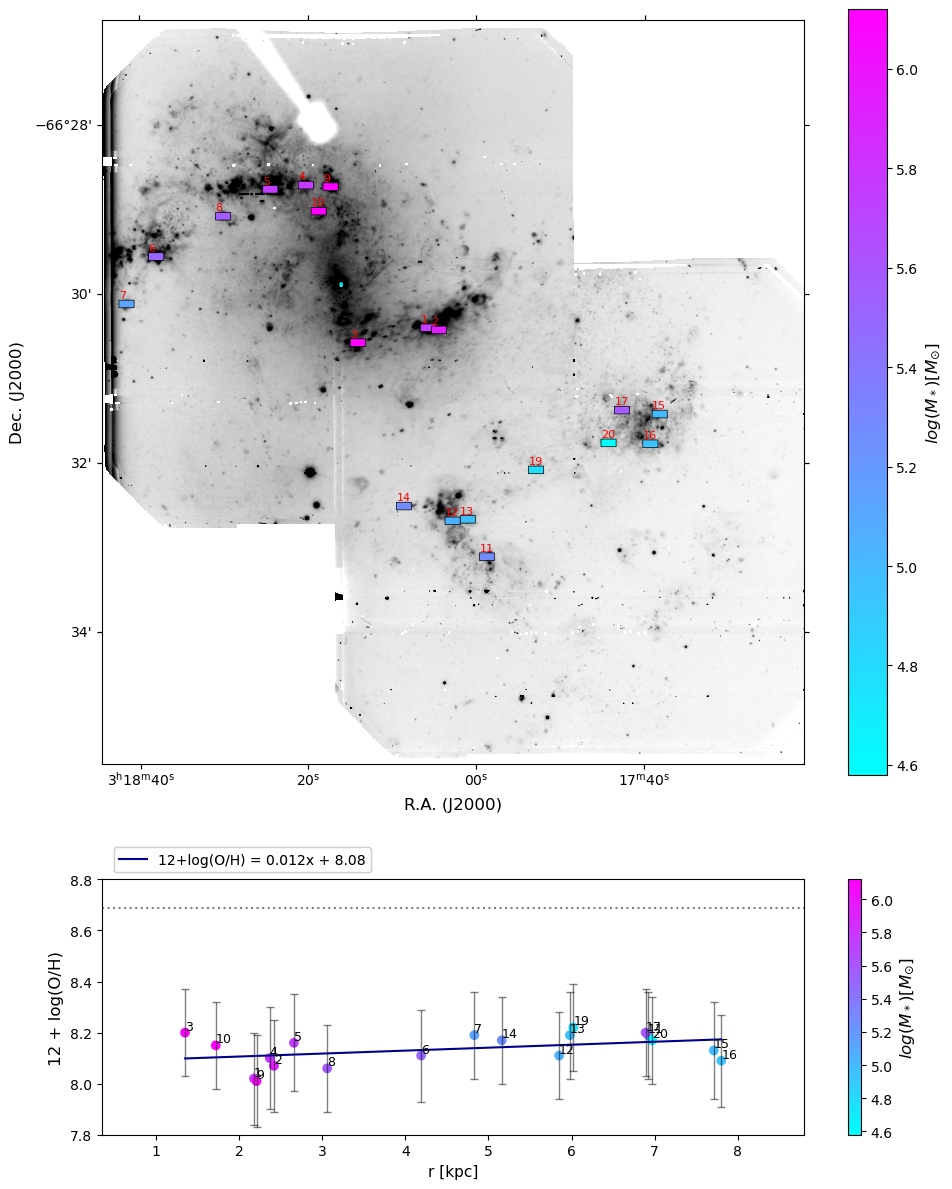

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Rectangle, Circle
from matplotlib.cm import ScalarMappable
from scipy.stats import chi2
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

# Parámetro para las colorbars
color_param = 'mass'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Gyr]',
    'n_e': 'n$_e$ [cm$^{-3}$]'
}

# Cargar datos
df_gradient = pd.read_csv('gradiente_scarano_ne_masa_edad_newnumber_ne10.csv', delimiter=',')
df_slits = pd.read_csv('output_scarano.csv')
#df_signed = pd.read_csv('signed_distances.csv', delimiter=',')
#df_gradient = pd.merge(df_gradient, df_signed, on='ID')

# Definir grupos
#group_left_galaxy = df_gradient[df_gradient['signed_distance_kpc'] < 0]
#group_right_galaxy = df_gradient[df_gradient['signed_distance_kpc'] >= 0]
#group_clouds = df_gradient[df_gradient['ID'].isin(range(11, 20))]

# Verificar número de puntos en cada grupo
#print(f"Number of points in group_left: {len(group_left_galaxy)}")
#print(f"Number of points in group_right_galaxy: {len(group_right_galaxy)}")
#print(f"Number of points in group_clouds: {len(group_clouds)}")

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool

# Parámetros de los slits
width_deg = 0.0075
height_deg = 0.0015
ra_center = 49.566875
dec_center = -66.498250
circle_radius_deg = 0.0002

# Cargar imágenes FITS
hdul1 = fits.open('../../../reduccion/mrgS20190730S0157_add.fits')
data1 = hdul1['SCI'].data
wcs1 = WCS(hdul1['SCI'].header)

hdul2 = fits.open('../../../reduccion/mrgS20190730S0160_add.fits')
data2 = hdul2['SCI'].data
wcs2 = WCS(hdul2['SCI'].header)

# Enmascarar valores de bordes
data1 = np.where(data1 == 593.67285, np.nan, data1)
data2 = np.where(data2 == 380.0607, np.nan, data2)

# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)

# Configurar figura
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['r_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado
weights = 1 / sigma_y
coeffs, cov = np.polyfit(x, y, deg=1, w=weights, cov=True)
m, b = coeffs
m_err = np.sqrt(cov[0,0])
b_err = np.sqrt(cov[1,1])
y_pred = m * x + b
chi_squared = np.sum((y - y_pred)**2 / sigma_y**2)
dof = len(x) - 2
reduced_chi_squared = chi_squared / dof if dof > 0 else np.nan
p_value = 1 - chi2.cdf(chi_squared, dof)

# Ajuste lineal ponderado para Galaxia (Derecho)
# if len(group_right_galaxy) > 1:
#     x2 = group_right_galaxy['signed_distance_kpc'].values
#     y2 = group_right_galaxy['12_LOG_OH_N2'].values
#     sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
#     weights2 = 1 / sigma_y2
#     coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
#     m2, b2 = coeffs2
#     m2_err = np.sqrt(cov2[0,0])
#     b2_err = np.sqrt(cov2[1,1])
#     y_pred2 = m2 * x2 + b2
#     chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
#     dof2 = len(x2) - 2
#     reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
# else:
#     m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
# if len(group_clouds) > 1:
#     x3 = group_clouds['signed_distance_kpc'].values
#     y3 = group_clouds['12_LOG_OH_N2'].values
#     sigma_y3 = group_clouds['12_LOG_OH_N2_ERR'].values
#     weights3 = 1 / sigma_y3**2
#     m3, b3 = np.polyfit(x3, y3, deg=1, w=weights3)
#     y_pred3 = m3 * x3 + b3
#     chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
#     dof3 = len(x3) - 2
#     reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
# else:
#     m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov)
# Imprimir resultados
print(f"Pendiente: {m:.4f} ± {m_err:.4f}")
print(f"Intercepto:          {b:.4f}")
print(f"Chi-cuadrado:        {chi_squared:.2f}")
print(f"Chi-cuadrado red.:   {reduced_chi_squared:.2f}")
print(f"Grados de libertad:  {dof}")
print(f"p-valor del ajuste:  {p_value:.3f}")
# print("\nNubes (IDs 11-19):")
# print(f"Pendiente: {m3:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
# print(f"Intercepto: {b3:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
# print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión

x_fit = np.linspace(np.min(x), np.max(x), 100)
y_fit = m * x_fit + b
line, = ax2.plot(x_fit, y_fit, color='darkblue', label=f"12+log(O/H) = {m:.3f}x + {b:.2f}")

# if len(group_right_galaxy) > 1 and not np.isnan(m2):
#     x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
#     y_fit2 = m2 * x_fit2 + b2
#     line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Galaxy right = {m2:.3f}x + {b2:.2f}")
#     print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
#     print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

# if len(group_clouds) > 1 and not np.isnan(m3):
#     x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
#     y_fit3 = m3 * x_fit3 + b3
#     line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea vertical en y=8.69
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas

legend = ax2.legend(handles=[line], loc='lower center', bbox_to_anchor=(0.2, 1.0))   
ax2.add_artist(legend)
# if len(group_right_galaxy) > 1 and not np.isnan(m2):
#     legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.65, 1.0))
#     ax2.add_artist(legend2)
# if len(group_clouds) > 1 and not np.isnan(m3):
#     legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
#     ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/2001161192.py:17: SyntaxWarning: invalid escape sequence '\o'
  'mass': '$log(M_*)[M_{\odot}]$',
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/2001161192.py:69: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[ 4.03841358e-05 -1.85152018e-04]
 [-1.85152018e-04  1.03397464e-03]]
Pendiente: 0.0116 ± 0.0064
Intercepto:          8.0830
Chi-cuadrado:        1.94
Chi-cuadrado red.:   0.11
Grados de libertad:  17
p-valor del ajuste:  1.000


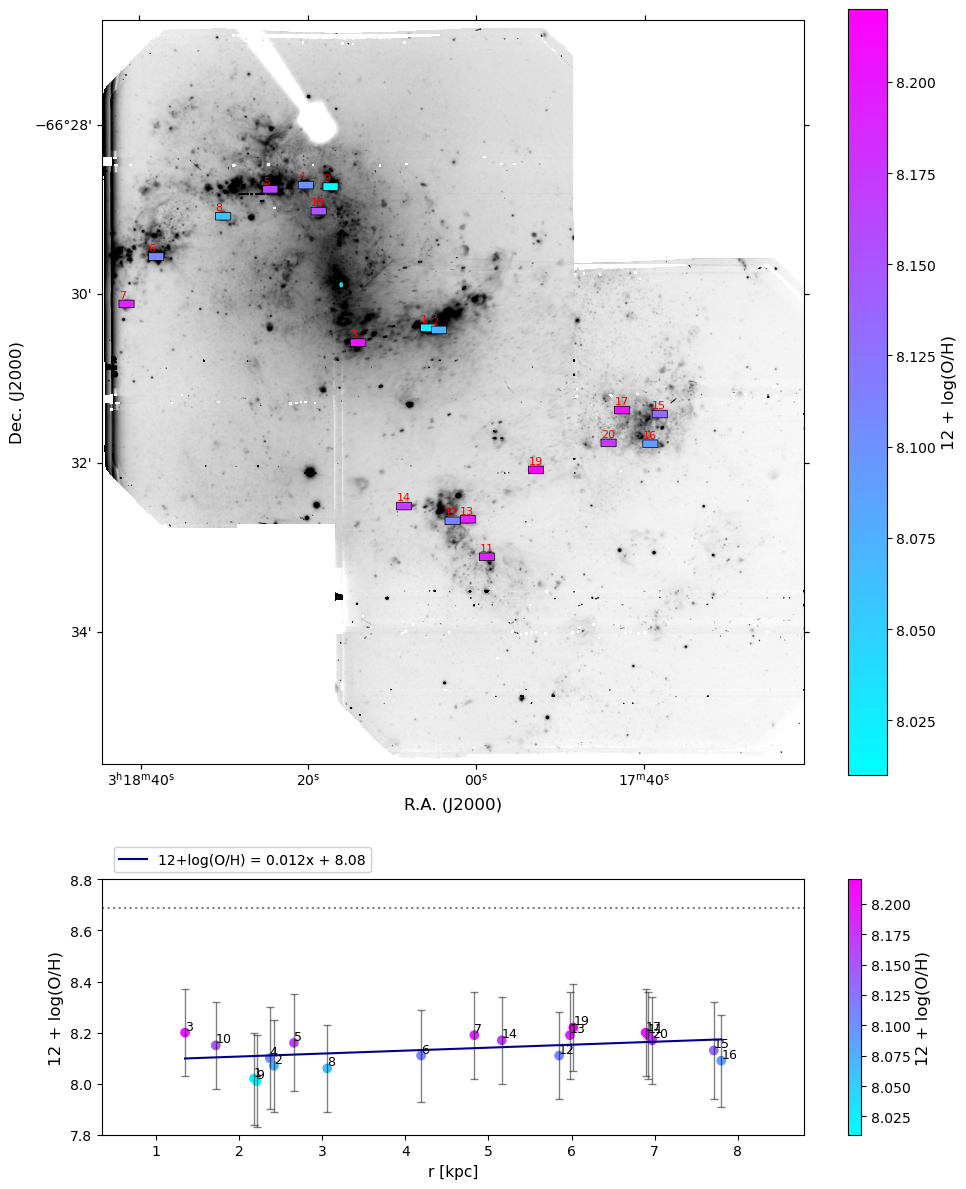

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Rectangle, Circle
from matplotlib.cm import ScalarMappable
from scipy.stats import chi2
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

# Parámetro para las colorbars
color_param = '12_LOG_OH_N2'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Gyr]',
    'n_e': 'n$_e$ [cm$^{-3}$]'
}

# Cargar datos
df_gradient = pd.read_csv('gradiente_scarano_ne_masa_edad_newnumber_ne10.csv', delimiter=',')
df_slits = pd.read_csv('output_scarano.csv')
#df_signed = pd.read_csv('signed_distances.csv', delimiter=',')
#df_gradient = pd.merge(df_gradient, df_signed, on='ID')

# Definir grupos
#group_left_galaxy = df_gradient[df_gradient['signed_distance_kpc'] < 0]
#group_right_galaxy = df_gradient[df_gradient['signed_distance_kpc'] >= 0]
#group_clouds = df_gradient[df_gradient['ID'].isin(range(11, 20))]

# Verificar número de puntos en cada grupo
#print(f"Number of points in group_left: {len(group_left_galaxy)}")
#print(f"Number of points in group_right_galaxy: {len(group_right_galaxy)}")
#print(f"Number of points in group_clouds: {len(group_clouds)}")

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool

# Parámetros de los slits
width_deg = 0.0075
height_deg = 0.0015
ra_center = 49.566875
dec_center = -66.498250
circle_radius_deg = 0.0002

# Cargar imágenes FITS
hdul1 = fits.open('../../../reduccion/mrgS20190730S0157_add.fits')
data1 = hdul1['SCI'].data
wcs1 = WCS(hdul1['SCI'].header)

hdul2 = fits.open('../../../reduccion/mrgS20190730S0160_add.fits')
data2 = hdul2['SCI'].data
wcs2 = WCS(hdul2['SCI'].header)

# Enmascarar valores de bordes
data1 = np.where(data1 == 593.67285, np.nan, data1)
data2 = np.where(data2 == 380.0607, np.nan, data2)

# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)

# Configurar figura
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['r_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado
weights = 1 / sigma_y
coeffs, cov = np.polyfit(x, y, deg=1, w=weights, cov=True)
m, b = coeffs
m_err = np.sqrt(cov[0,0])
b_err = np.sqrt(cov[1,1])
y_pred = m * x + b
chi_squared = np.sum((y - y_pred)**2 / sigma_y**2)
dof = len(x) - 2
reduced_chi_squared = chi_squared / dof if dof > 0 else np.nan
p_value = 1 - chi2.cdf(chi_squared, dof)

# Ajuste lineal ponderado para Galaxia (Derecho)
# if len(group_right_galaxy) > 1:
#     x2 = group_right_galaxy['signed_distance_kpc'].values
#     y2 = group_right_galaxy['12_LOG_OH_N2'].values
#     sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
#     weights2 = 1 / sigma_y2
#     coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
#     m2, b2 = coeffs2
#     m2_err = np.sqrt(cov2[0,0])
#     b2_err = np.sqrt(cov2[1,1])
#     y_pred2 = m2 * x2 + b2
#     chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
#     dof2 = len(x2) - 2
#     reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
# else:
#     m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
# if len(group_clouds) > 1:
#     x3 = group_clouds['signed_distance_kpc'].values
#     y3 = group_clouds['12_LOG_OH_N2'].values
#     sigma_y3 = group_clouds['12_LOG_OH_N2_ERR'].values
#     weights3 = 1 / sigma_y3**2
#     m3, b3 = np.polyfit(x3, y3, deg=1, w=weights3)
#     y_pred3 = m3 * x3 + b3
#     chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
#     dof3 = len(x3) - 2
#     reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
# else:
#     m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov)
# Imprimir resultados
print(f"Pendiente: {m:.4f} ± {m_err:.4f}")
print(f"Intercepto:          {b:.4f}")
print(f"Chi-cuadrado:        {chi_squared:.2f}")
print(f"Chi-cuadrado red.:   {reduced_chi_squared:.2f}")
print(f"Grados de libertad:  {dof}")
print(f"p-valor del ajuste:  {p_value:.3f}")
# print("\nNubes (IDs 11-19):")
# print(f"Pendiente: {m3:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
# print(f"Intercepto: {b3:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
# print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión

x_fit = np.linspace(np.min(x), np.max(x), 100)
y_fit = m * x_fit + b
line, = ax2.plot(x_fit, y_fit, color='darkblue', label=f"12+log(O/H) = {m:.3f}x + {b:.2f}")

# if len(group_right_galaxy) > 1 and not np.isnan(m2):
#     x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
#     y_fit2 = m2 * x_fit2 + b2
#     line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Galaxy right = {m2:.3f}x + {b2:.2f}")
#     print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
#     print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

# if len(group_clouds) > 1 and not np.isnan(m3):
#     x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
#     y_fit3 = m3 * x_fit3 + b3
#     line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea vertical en y=8.69
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas

legend = ax2.legend(handles=[line], loc='lower center', bbox_to_anchor=(0.2, 1.0))   
ax2.add_artist(legend)
# if len(group_right_galaxy) > 1 and not np.isnan(m2):
#     legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.65, 1.0))
#     ax2.add_artist(legend2)
# if len(group_clouds) > 1 and not np.isnan(m3):
#     legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
#     ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/1174357118.py:17: SyntaxWarning: invalid escape sequence '\o'
  'mass': '$log(M_*)[M_{\odot}]$',
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/1174357118.py:69: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[ 4.03841358e-05 -1.85152018e-04]
 [-1.85152018e-04  1.03397464e-03]]
Pendiente: 0.0116 ± 0.0064
Intercepto:          8.0830
Chi-cuadrado:        1.94
Chi-cuadrado red.:   0.11
Grados de libertad:  17
p-valor del ajuste:  1.000


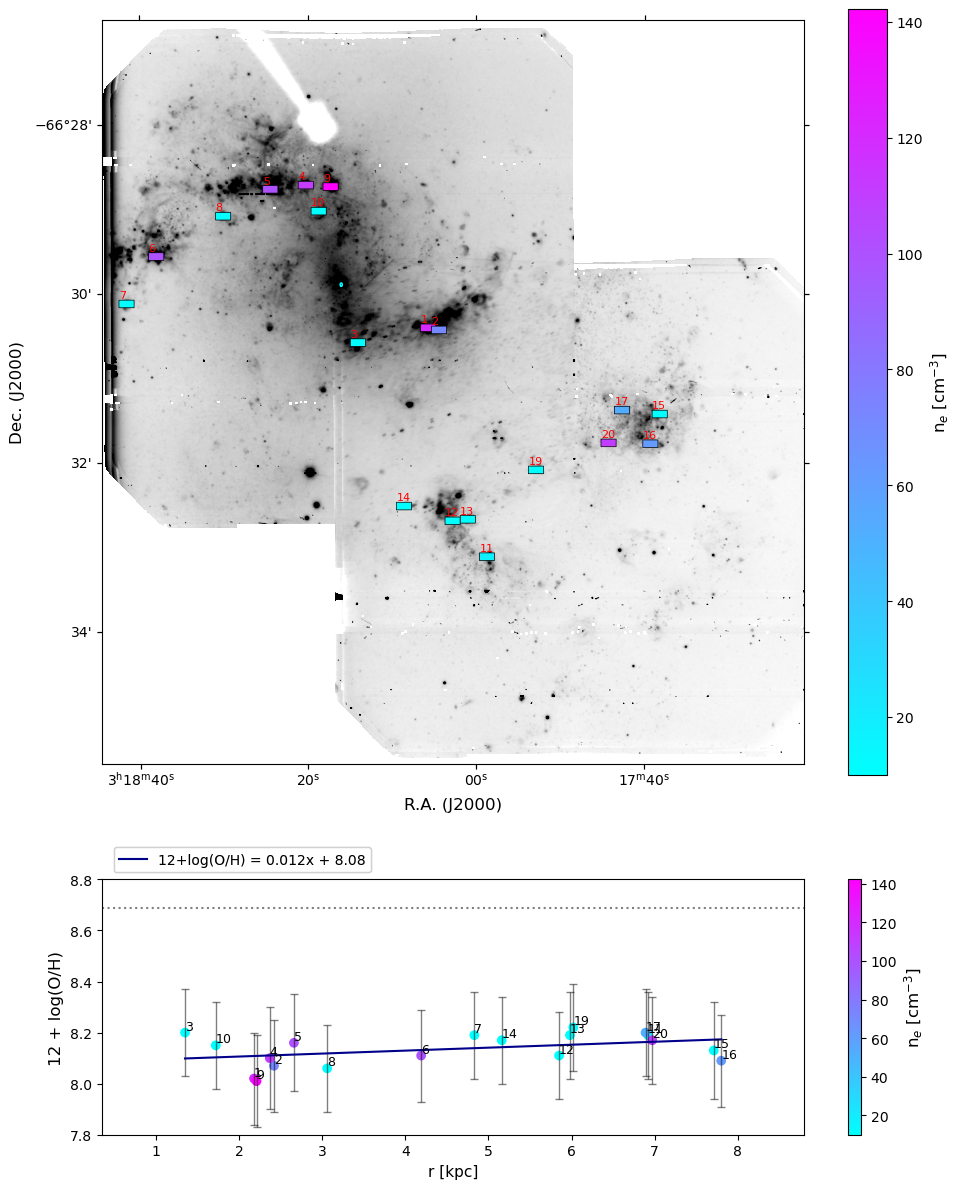

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Rectangle, Circle
from matplotlib.cm import ScalarMappable
from scipy.stats import chi2
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

# Parámetro para las colorbars
color_param = 'n_e'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Gyr]',
    'n_e': 'n$_e$ [cm$^{-3}$]'
}

# Cargar datos
df_gradient = pd.read_csv('gradiente_scarano_ne_masa_edad_newnumber_ne10.csv', delimiter=',')
df_slits = pd.read_csv('output_scarano.csv')
#df_signed = pd.read_csv('signed_distances.csv', delimiter=',')
#df_gradient = pd.merge(df_gradient, df_signed, on='ID')

# Definir grupos
#group_left_galaxy = df_gradient[df_gradient['signed_distance_kpc'] < 0]
#group_right_galaxy = df_gradient[df_gradient['signed_distance_kpc'] >= 0]
#group_clouds = df_gradient[df_gradient['ID'].isin(range(11, 20))]

# Verificar número de puntos en cada grupo
#print(f"Number of points in group_left: {len(group_left_galaxy)}")
#print(f"Number of points in group_right_galaxy: {len(group_right_galaxy)}")
#print(f"Number of points in group_clouds: {len(group_clouds)}")

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool

# Parámetros de los slits
width_deg = 0.0075
height_deg = 0.0015
ra_center = 49.566875
dec_center = -66.498250
circle_radius_deg = 0.0002

# Cargar imágenes FITS
hdul1 = fits.open('../../../reduccion/mrgS20190730S0157_add.fits')
data1 = hdul1['SCI'].data
wcs1 = WCS(hdul1['SCI'].header)

hdul2 = fits.open('../../../reduccion/mrgS20190730S0160_add.fits')
data2 = hdul2['SCI'].data
wcs2 = WCS(hdul2['SCI'].header)

# Enmascarar valores de bordes
data1 = np.where(data1 == 593.67285, np.nan, data1)
data2 = np.where(data2 == 380.0607, np.nan, data2)

# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)

# Configurar figura
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['r_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado
weights = 1 / sigma_y
coeffs, cov = np.polyfit(x, y, deg=1, w=weights, cov=True)
m, b = coeffs
m_err = np.sqrt(cov[0,0])
b_err = np.sqrt(cov[1,1])
y_pred = m * x + b
chi_squared = np.sum((y - y_pred)**2 / sigma_y**2)
dof = len(x) - 2
reduced_chi_squared = chi_squared / dof if dof > 0 else np.nan
p_value = 1 - chi2.cdf(chi_squared, dof)

# Ajuste lineal ponderado para Galaxia (Derecho)
# if len(group_right_galaxy) > 1:
#     x2 = group_right_galaxy['signed_distance_kpc'].values
#     y2 = group_right_galaxy['12_LOG_OH_N2'].values
#     sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
#     weights2 = 1 / sigma_y2
#     coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
#     m2, b2 = coeffs2
#     m2_err = np.sqrt(cov2[0,0])
#     b2_err = np.sqrt(cov2[1,1])
#     y_pred2 = m2 * x2 + b2
#     chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
#     dof2 = len(x2) - 2
#     reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
# else:
#     m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
# if len(group_clouds) > 1:
#     x3 = group_clouds['signed_distance_kpc'].values
#     y3 = group_clouds['12_LOG_OH_N2'].values
#     sigma_y3 = group_clouds['12_LOG_OH_N2_ERR'].values
#     weights3 = 1 / sigma_y3**2
#     m3, b3 = np.polyfit(x3, y3, deg=1, w=weights3)
#     y_pred3 = m3 * x3 + b3
#     chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
#     dof3 = len(x3) - 2
#     reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
# else:
#     m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov)
# Imprimir resultados
print(f"Pendiente: {m:.4f} ± {m_err:.4f}")
print(f"Intercepto:          {b:.4f}")
print(f"Chi-cuadrado:        {chi_squared:.2f}")
print(f"Chi-cuadrado red.:   {reduced_chi_squared:.2f}")
print(f"Grados de libertad:  {dof}")
print(f"p-valor del ajuste:  {p_value:.3f}")
# print("\nNubes (IDs 11-19):")
# print(f"Pendiente: {m3:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
# print(f"Intercepto: {b3:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
# print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión

x_fit = np.linspace(np.min(x), np.max(x), 100)
y_fit = m * x_fit + b
line, = ax2.plot(x_fit, y_fit, color='darkblue', label=f"12+log(O/H) = {m:.3f}x + {b:.2f}")

# if len(group_right_galaxy) > 1 and not np.isnan(m2):
#     x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
#     y_fit2 = m2 * x_fit2 + b2
#     line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Galaxy right = {m2:.3f}x + {b2:.2f}")
#     print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
#     print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

# if len(group_clouds) > 1 and not np.isnan(m3):
#     x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
#     y_fit3 = m3 * x_fit3 + b3
#     line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea vertical en y=8.69
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas

legend = ax2.legend(handles=[line], loc='lower center', bbox_to_anchor=(0.2, 1.0))   
ax2.add_artist(legend)
# if len(group_right_galaxy) > 1 and not np.isnan(m2):
#     legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.65, 1.0))
#     ax2.add_artist(legend2)
# if len(group_clouds) > 1 and not np.isnan(m3):
#     legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
#     ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

GRADIENTE RADIAL GALAXY SEPARADO DE CLOUDS

GRADIENTE GALACTOCÉNTRICO IZQ Y DERECHA TODO JUNTO

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:178: SyntaxWarning: invalid escape sequence '\L'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:178: SyntaxWarning: invalid escape sequence '\L'
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/3266110050.py:17: SyntaxWarning: invalid escape sequence '\o'
  'mass': '$log(M_*)[M_{\odot}]$',
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/3266110050.py:178: SyntaxWarning: invalid escape sequence '\L'
  print("\Lado Derecho (signed_distance_kpc >= 0):")


Number of points in group_left: 7
Number of points in group_right_galaxy: 12


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/3266110050.py:69: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[0.00068865 0.00176477]
 [0.00176477 0.00512275]]
Lado Izquierdo (signed_distance_kpc < 0):
Pendiente: -0.0215
Intercepto: 8.0571
Chi-cuadrado red.: 0.13
\Lado Derecho (signed_distance_kpc >= 0):
Pendiente: 0.0073
Intercepto: 8.1125
Chi-cuadrado red.: 0.13
x_fit2 range: 1.0566975100962768 to 7.715021937410652
y_fit2 range: 8.120172098054063 to 8.168532374608429


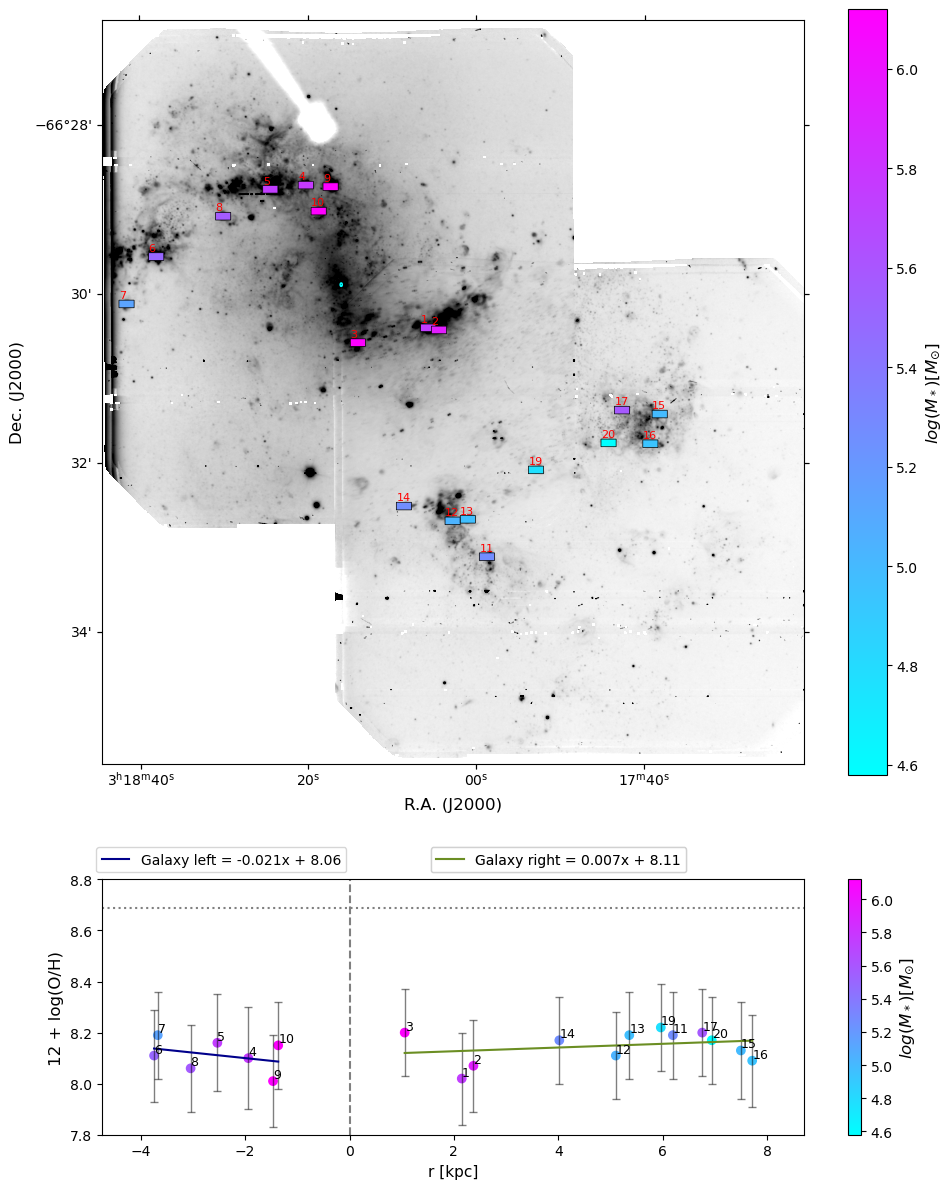

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Rectangle, Circle
from matplotlib.cm import ScalarMappable
from scipy.stats import chi2
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

# Parámetro para las colorbars
color_param = 'mass'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Gyr]',
    'n_e': 'n$_e$ [cm$^{-3}$]'
}

# Cargar datos
df_gradient = pd.read_csv('gradiente_scarano_ne_masa_edad_newnumber_ne10.csv', delimiter=',')
df_slits = pd.read_csv('output_scarano.csv')
df_signed = pd.read_csv('signed_distances.csv', delimiter=',')
df_gradient = pd.merge(df_gradient, df_signed, on='ID')

# Definir grupos
group_left_galaxy = df_gradient[df_gradient['signed_distance_kpc'] < 0]
group_right_galaxy = df_gradient[df_gradient['signed_distance_kpc'] >= 0]
#group_clouds = df_gradient[df_gradient['ID'].isin(range(11, 20))]

# Verificar número de puntos en cada grupo
print(f"Number of points in group_left: {len(group_left_galaxy)}")
print(f"Number of points in group_right_galaxy: {len(group_right_galaxy)}")
#print(f"Number of points in group_clouds: {len(group_clouds)}")

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool

# Parámetros de los slits
width_deg = 0.0075
height_deg = 0.0015
ra_center = 49.566875
dec_center = -66.498250
circle_radius_deg = 0.0002

# Cargar imágenes FITS
hdul1 = fits.open('../../../reduccion/mrgS20190730S0157_add.fits')
data1 = hdul1['SCI'].data
wcs1 = WCS(hdul1['SCI'].header)

hdul2 = fits.open('../../../reduccion/mrgS20190730S0160_add.fits')
data2 = hdul2['SCI'].data
wcs2 = WCS(hdul2['SCI'].header)

# Enmascarar valores de bordes
data1 = np.where(data1 == 593.67285, np.nan, data1)
data2 = np.where(data2 == 380.0607, np.nan, data2)

# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)

# Configurar figura
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['signed_distance_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado para Lado Izquierdo
if len(group_left_galaxy) > 1:
    x1 = group_left_galaxy['signed_distance_kpc'].values
    y1 = group_left_galaxy['12_LOG_OH_N2'].values
    sigma_y1 = group_left_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights1 = 1 / sigma_y1
    coeffs1, cov1 = np.polyfit(x1, y1, deg=1, w=weights1, cov=True)
    m1, b1 = coeffs1
    m1_err = np.sqrt(cov1[0,0])
    b1_err = np.sqrt(cov1[1,1])
    y_pred1 = m1 * x1 + b1
    chi_squared1 = np.sum((y1 - y_pred1)**2 / sigma_y1**2)
    dof1 = len(x1) - 2
    reduced_chi_squared1 = chi_squared1 / dof1 if dof1 > 0 else np.nan
else:
    m1, b1, reduced_chi_squared1 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Galaxia (Derecho)
if len(group_right_galaxy) > 1:
    x2 = group_right_galaxy['signed_distance_kpc'].values
    y2 = group_right_galaxy['12_LOG_OH_N2'].values
    sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights2 = 1 / sigma_y2
    coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
    m2, b2 = coeffs2
    m2_err = np.sqrt(cov2[0,0])
    b2_err = np.sqrt(cov2[1,1])
    y_pred2 = m2 * x2 + b2
    chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
    dof2 = len(x2) - 2
    reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
else:
    m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
# if len(group_clouds) > 1:
#     x3 = group_clouds['signed_distance_kpc'].values
#     y3 = group_clouds['12_LOG_OH_N2'].values
#     sigma_y3 = group_clouds['12_LOG_OH_N2_ERR'].values
#     weights3 = 1 / sigma_y3**2
#     m3, b3 = np.polyfit(x3, y3, deg=1, w=weights3)
#     y_pred3 = m3 * x3 + b3
#     chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
#     dof3 = len(x3) - 2
#     reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
# else:
#     m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov1)
print("Lado Izquierdo (signed_distance_kpc < 0):")
print(f"Pendiente: {m1:.4f}" if not np.isnan(m1) else "Pendiente: N/A")
print(f"Intercepto: {b1:.4f}" if not np.isnan(b1) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared1:.2f}" if not np.isnan(reduced_chi_squared1) else "Chi-cuadrado red.: N/A")
print("\Lado Derecho (signed_distance_kpc >= 0):")
print(f"Pendiente: {m2:.4f}" if not np.isnan(m2) else "Pendiente: N/A")
print(f"Intercepto: {b2:.4f}" if not np.isnan(b2) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared2:.2f}" if not np.isnan(reduced_chi_squared2) else "Chi-cuadrado red.: N/A")
# print("\nNubes (IDs 11-19):")
# print(f"Pendiente: {m3:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
# print(f"Intercepto: {b3:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
# print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    x_fit1 = np.linspace(np.min(x1), np.max(x1), 100)
    y_fit1 = m1 * x_fit1 + b1
    line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Galaxy left = {m1:.3f}x + {b1:.2f}")

if len(group_right_galaxy) > 1 and not np.isnan(m2):
    x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
    y_fit2 = m2 * x_fit2 + b2
    line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Galaxy right = {m2:.3f}x + {b2:.2f}")
    print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
    print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

# if len(group_clouds) > 1 and not np.isnan(m3):
#     x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
#     y_fit3 = m3 * x_fit3 + b3
#     line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea vertical en y=8.69
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    legend1 = ax2.legend(handles=[line1], loc='lower center', bbox_to_anchor=(0.17, 1.0))   
    ax2.add_artist(legend1)
if len(group_right_galaxy) > 1 and not np.isnan(m2):
    legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.65, 1.0))
    ax2.add_artist(legend2)
# if len(group_clouds) > 1 and not np.isnan(m3):
#     legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
#     ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:178: SyntaxWarning: invalid escape sequence '\L'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:178: SyntaxWarning: invalid escape sequence '\L'
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/2666009606.py:17: SyntaxWarning: invalid escape sequence '\o'
  'mass': '$log(M_*)[M_{\odot}]$',
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/2666009606.py:178: SyntaxWarning: invalid escape sequence '\L'
  print("\Lado Derecho (signed_distance_kpc >= 0):")


Number of points in group_left: 7
Number of points in group_right_galaxy: 12


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/2666009606.py:69: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[0.00068865 0.00176477]
 [0.00176477 0.00512275]]
Lado Izquierdo (signed_distance_kpc < 0):
Pendiente: -0.0215
Intercepto: 8.0571
Chi-cuadrado red.: 0.13
\Lado Derecho (signed_distance_kpc >= 0):
Pendiente: 0.0073
Intercepto: 8.1125
Chi-cuadrado red.: 0.13
x_fit2 range: 1.0566975100962768 to 7.715021937410652
y_fit2 range: 8.120172098054063 to 8.168532374608429


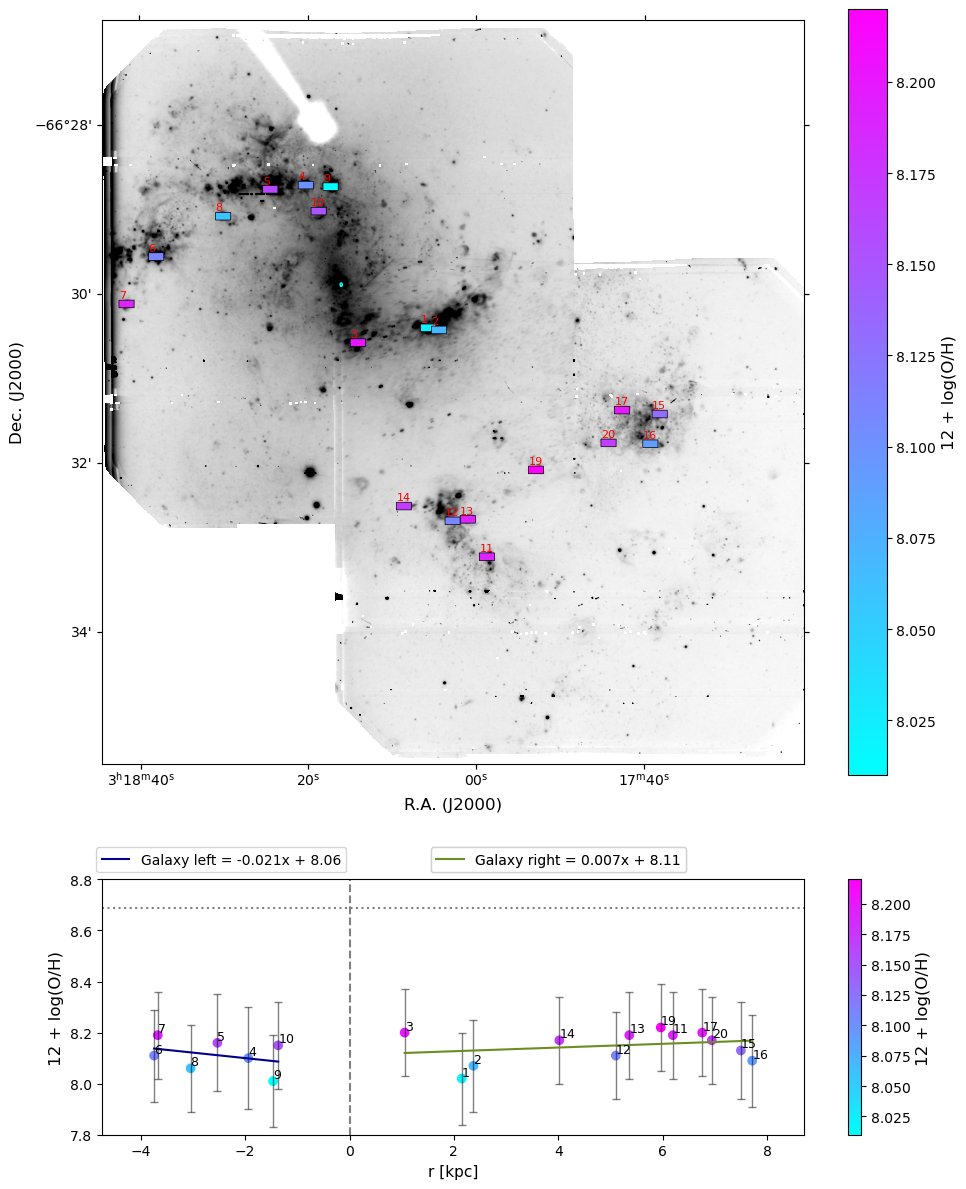

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Rectangle, Circle
from matplotlib.cm import ScalarMappable
from scipy.stats import chi2
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

# Parámetro para las colorbars
color_param = '12_LOG_OH_N2'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Gyr]',
    'n_e': 'n$_e$ [cm$^{-3}$]'
}

# Cargar datos
df_gradient = pd.read_csv('gradiente_scarano_ne_masa_edad_newnumber_ne10.csv', delimiter=',')
df_slits = pd.read_csv('output_scarano.csv')
df_signed = pd.read_csv('signed_distances.csv', delimiter=',')
df_gradient = pd.merge(df_gradient, df_signed, on='ID')

# Definir grupos
group_left_galaxy = df_gradient[df_gradient['signed_distance_kpc'] < 0]
group_right_galaxy = df_gradient[df_gradient['signed_distance_kpc'] >= 0]
#group_clouds = df_gradient[df_gradient['ID'].isin(range(11, 20))]

# Verificar número de puntos en cada grupo
print(f"Number of points in group_left: {len(group_left_galaxy)}")
print(f"Number of points in group_right_galaxy: {len(group_right_galaxy)}")
#print(f"Number of points in group_clouds: {len(group_clouds)}")

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool

# Parámetros de los slits
width_deg = 0.0075
height_deg = 0.0015
ra_center = 49.566875
dec_center = -66.498250
circle_radius_deg = 0.0002

# Cargar imágenes FITS
hdul1 = fits.open('../../../reduccion/mrgS20190730S0157_add.fits')
data1 = hdul1['SCI'].data
wcs1 = WCS(hdul1['SCI'].header)

hdul2 = fits.open('../../../reduccion/mrgS20190730S0160_add.fits')
data2 = hdul2['SCI'].data
wcs2 = WCS(hdul2['SCI'].header)

# Enmascarar valores de bordes
data1 = np.where(data1 == 593.67285, np.nan, data1)
data2 = np.where(data2 == 380.0607, np.nan, data2)

# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)

# Configurar figura
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['signed_distance_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado para Lado Izquierdo
if len(group_left_galaxy) > 1:
    x1 = group_left_galaxy['signed_distance_kpc'].values
    y1 = group_left_galaxy['12_LOG_OH_N2'].values
    sigma_y1 = group_left_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights1 = 1 / sigma_y1
    coeffs1, cov1 = np.polyfit(x1, y1, deg=1, w=weights1, cov=True)
    m1, b1 = coeffs1
    m1_err = np.sqrt(cov1[0,0])
    b1_err = np.sqrt(cov1[1,1])
    y_pred1 = m1 * x1 + b1
    chi_squared1 = np.sum((y1 - y_pred1)**2 / sigma_y1**2)
    dof1 = len(x1) - 2
    reduced_chi_squared1 = chi_squared1 / dof1 if dof1 > 0 else np.nan
else:
    m1, b1, reduced_chi_squared1 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Galaxia (Derecho)
if len(group_right_galaxy) > 1:
    x2 = group_right_galaxy['signed_distance_kpc'].values
    y2 = group_right_galaxy['12_LOG_OH_N2'].values
    sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights2 = 1 / sigma_y2
    coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
    m2, b2 = coeffs2
    m2_err = np.sqrt(cov2[0,0])
    b2_err = np.sqrt(cov2[1,1])
    y_pred2 = m2 * x2 + b2
    chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
    dof2 = len(x2) - 2
    reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
else:
    m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
# if len(group_clouds) > 1:
#     x3 = group_clouds['signed_distance_kpc'].values
#     y3 = group_clouds['12_LOG_OH_N2'].values
#     sigma_y3 = group_clouds['12_LOG_OH_N2_ERR'].values
#     weights3 = 1 / sigma_y3**2
#     m3, b3 = np.polyfit(x3, y3, deg=1, w=weights3)
#     y_pred3 = m3 * x3 + b3
#     chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
#     dof3 = len(x3) - 2
#     reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
# else:
#     m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov1)
print("Lado Izquierdo (signed_distance_kpc < 0):")
print(f"Pendiente: {m1:.4f}" if not np.isnan(m1) else "Pendiente: N/A")
print(f"Intercepto: {b1:.4f}" if not np.isnan(b1) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared1:.2f}" if not np.isnan(reduced_chi_squared1) else "Chi-cuadrado red.: N/A")
print("\Lado Derecho (signed_distance_kpc >= 0):")
print(f"Pendiente: {m2:.4f}" if not np.isnan(m2) else "Pendiente: N/A")
print(f"Intercepto: {b2:.4f}" if not np.isnan(b2) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared2:.2f}" if not np.isnan(reduced_chi_squared2) else "Chi-cuadrado red.: N/A")
# print("\nNubes (IDs 11-19):")
# print(f"Pendiente: {m3:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
# print(f"Intercepto: {b3:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
# print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    x_fit1 = np.linspace(np.min(x1), np.max(x1), 100)
    y_fit1 = m1 * x_fit1 + b1
    line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Galaxy left = {m1:.3f}x + {b1:.2f}")

if len(group_right_galaxy) > 1 and not np.isnan(m2):
    x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
    y_fit2 = m2 * x_fit2 + b2
    line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Galaxy right = {m2:.3f}x + {b2:.2f}")
    print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
    print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

# if len(group_clouds) > 1 and not np.isnan(m3):
#     x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
#     y_fit3 = m3 * x_fit3 + b3
#     line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea vertical en y=8.69
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    legend1 = ax2.legend(handles=[line1], loc='lower center', bbox_to_anchor=(0.17, 1.0))   
    ax2.add_artist(legend1)
if len(group_right_galaxy) > 1 and not np.isnan(m2):
    legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.65, 1.0))
    ax2.add_artist(legend2)
# if len(group_clouds) > 1 and not np.isnan(m3):
#     legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
#     ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:178: SyntaxWarning: invalid escape sequence '\L'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:178: SyntaxWarning: invalid escape sequence '\L'
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/1853603020.py:17: SyntaxWarning: invalid escape sequence '\o'
  'mass': '$log(M_*)[M_{\odot}]$',
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/1853603020.py:178: SyntaxWarning: invalid escape sequence '\L'
  print("\Lado Derecho (signed_distance_kpc >= 0):")


Number of points in group_left: 7
Number of points in group_right_galaxy: 12


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/1853603020.py:69: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[0.00068865 0.00176477]
 [0.00176477 0.00512275]]
Lado Izquierdo (signed_distance_kpc < 0):
Pendiente: -0.0215
Intercepto: 8.0571
Chi-cuadrado red.: 0.13
\Lado Derecho (signed_distance_kpc >= 0):
Pendiente: 0.0073
Intercepto: 8.1125
Chi-cuadrado red.: 0.13
x_fit2 range: 1.0566975100962768 to 7.715021937410652
y_fit2 range: 8.120172098054063 to 8.168532374608429


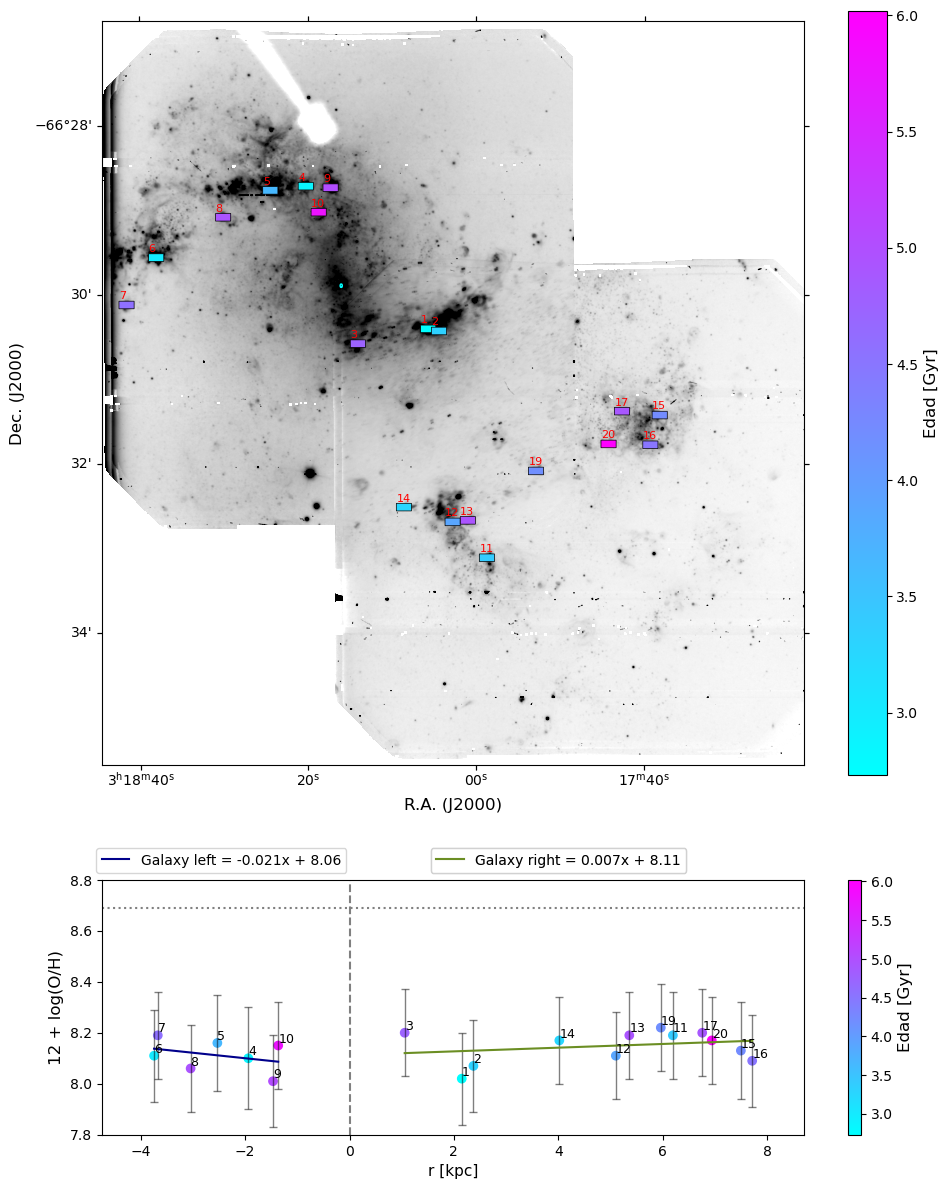

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Rectangle, Circle
from matplotlib.cm import ScalarMappable
from scipy.stats import chi2
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

# Parámetro para las colorbars
color_param = 'age'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Gyr]',
    'n_e': 'n$_e$ [cm$^{-3}$]'
}

# Cargar datos
df_gradient = pd.read_csv('gradiente_scarano_ne_masa_edad_newnumber_ne10.csv', delimiter=',')
df_slits = pd.read_csv('output_scarano.csv')
df_signed = pd.read_csv('signed_distances.csv', delimiter=',')
df_gradient = pd.merge(df_gradient, df_signed, on='ID')

# Definir grupos
group_left_galaxy = df_gradient[df_gradient['signed_distance_kpc'] < 0]
group_right_galaxy = df_gradient[df_gradient['signed_distance_kpc'] >= 0]
#group_clouds = df_gradient[df_gradient['ID'].isin(range(11, 20))]

# Verificar número de puntos en cada grupo
print(f"Number of points in group_left: {len(group_left_galaxy)}")
print(f"Number of points in group_right_galaxy: {len(group_right_galaxy)}")
#print(f"Number of points in group_clouds: {len(group_clouds)}")

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool

# Parámetros de los slits
width_deg = 0.0075
height_deg = 0.0015
ra_center = 49.566875
dec_center = -66.498250
circle_radius_deg = 0.0002

# Cargar imágenes FITS
hdul1 = fits.open('../../../reduccion/mrgS20190730S0157_add.fits')
data1 = hdul1['SCI'].data
wcs1 = WCS(hdul1['SCI'].header)

hdul2 = fits.open('../../../reduccion/mrgS20190730S0160_add.fits')
data2 = hdul2['SCI'].data
wcs2 = WCS(hdul2['SCI'].header)

# Enmascarar valores de bordes
data1 = np.where(data1 == 593.67285, np.nan, data1)
data2 = np.where(data2 == 380.0607, np.nan, data2)

# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)

# Configurar figura
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['signed_distance_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado para Lado Izquierdo
if len(group_left_galaxy) > 1:
    x1 = group_left_galaxy['signed_distance_kpc'].values
    y1 = group_left_galaxy['12_LOG_OH_N2'].values
    sigma_y1 = group_left_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights1 = 1 / sigma_y1
    coeffs1, cov1 = np.polyfit(x1, y1, deg=1, w=weights1, cov=True)
    m1, b1 = coeffs1
    m1_err = np.sqrt(cov1[0,0])
    b1_err = np.sqrt(cov1[1,1])
    y_pred1 = m1 * x1 + b1
    chi_squared1 = np.sum((y1 - y_pred1)**2 / sigma_y1**2)
    dof1 = len(x1) - 2
    reduced_chi_squared1 = chi_squared1 / dof1 if dof1 > 0 else np.nan
else:
    m1, b1, reduced_chi_squared1 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Galaxia (Derecho)
if len(group_right_galaxy) > 1:
    x2 = group_right_galaxy['signed_distance_kpc'].values
    y2 = group_right_galaxy['12_LOG_OH_N2'].values
    sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights2 = 1 / sigma_y2
    coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
    m2, b2 = coeffs2
    m2_err = np.sqrt(cov2[0,0])
    b2_err = np.sqrt(cov2[1,1])
    y_pred2 = m2 * x2 + b2
    chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
    dof2 = len(x2) - 2
    reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
else:
    m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
# if len(group_clouds) > 1:
#     x3 = group_clouds['signed_distance_kpc'].values
#     y3 = group_clouds['12_LOG_OH_N2'].values
#     sigma_y3 = group_clouds['12_LOG_OH_N2_ERR'].values
#     weights3 = 1 / sigma_y3**2
#     m3, b3 = np.polyfit(x3, y3, deg=1, w=weights3)
#     y_pred3 = m3 * x3 + b3
#     chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
#     dof3 = len(x3) - 2
#     reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
# else:
#     m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov1)
print("Lado Izquierdo (signed_distance_kpc < 0):")
print(f"Pendiente: {m1:.4f}" if not np.isnan(m1) else "Pendiente: N/A")
print(f"Intercepto: {b1:.4f}" if not np.isnan(b1) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared1:.2f}" if not np.isnan(reduced_chi_squared1) else "Chi-cuadrado red.: N/A")
print("\Lado Derecho (signed_distance_kpc >= 0):")
print(f"Pendiente: {m2:.4f}" if not np.isnan(m2) else "Pendiente: N/A")
print(f"Intercepto: {b2:.4f}" if not np.isnan(b2) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared2:.2f}" if not np.isnan(reduced_chi_squared2) else "Chi-cuadrado red.: N/A")
# print("\nNubes (IDs 11-19):")
# print(f"Pendiente: {m3:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
# print(f"Intercepto: {b3:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
# print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    x_fit1 = np.linspace(np.min(x1), np.max(x1), 100)
    y_fit1 = m1 * x_fit1 + b1
    line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Galaxy left = {m1:.3f}x + {b1:.2f}")

if len(group_right_galaxy) > 1 and not np.isnan(m2):
    x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
    y_fit2 = m2 * x_fit2 + b2
    line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Galaxy right = {m2:.3f}x + {b2:.2f}")
    print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
    print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

# if len(group_clouds) > 1 and not np.isnan(m3):
#     x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
#     y_fit3 = m3 * x_fit3 + b3
#     line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea vertical en y=8.69
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    legend1 = ax2.legend(handles=[line1], loc='lower center', bbox_to_anchor=(0.17, 1.0))   
    ax2.add_artist(legend1)
if len(group_right_galaxy) > 1 and not np.isnan(m2):
    legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.65, 1.0))
    ax2.add_artist(legend2)
# if len(group_clouds) > 1 and not np.isnan(m3):
#     legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
#     ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:178: SyntaxWarning: invalid escape sequence '\L'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:178: SyntaxWarning: invalid escape sequence '\L'
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/1377186385.py:17: SyntaxWarning: invalid escape sequence '\o'
  'mass': '$log(M_*)[M_{\odot}]$',
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/1377186385.py:178: SyntaxWarning: invalid escape sequence '\L'
  print("\Lado Derecho (signed_distance_kpc >= 0):")


Number of points in group_left: 7
Number of points in group_right_galaxy: 12


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/1377186385.py:69: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[0.00068865 0.00176477]
 [0.00176477 0.00512275]]
Lado Izquierdo (signed_distance_kpc < 0):
Pendiente: -0.0215
Intercepto: 8.0571
Chi-cuadrado red.: 0.13
\Lado Derecho (signed_distance_kpc >= 0):
Pendiente: 0.0073
Intercepto: 8.1125
Chi-cuadrado red.: 0.13
x_fit2 range: 1.0566975100962768 to 7.715021937410652
y_fit2 range: 8.120172098054063 to 8.168532374608429


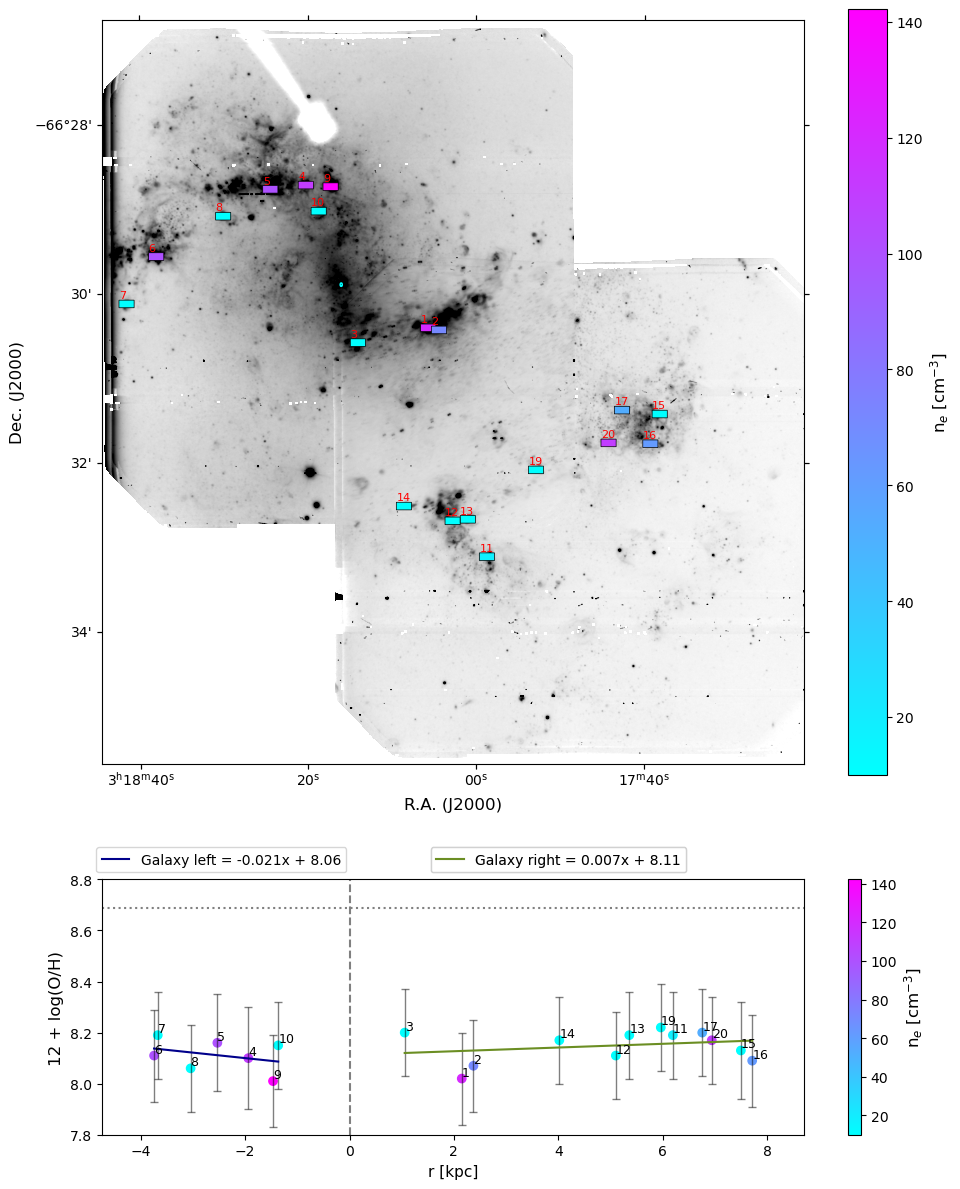

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Rectangle, Circle
from matplotlib.cm import ScalarMappable
from scipy.stats import chi2
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

# Parámetro para las colorbars
color_param = 'n_e'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Gyr]',
    'n_e': 'n$_e$ [cm$^{-3}$]'
}

# Cargar datos
df_gradient = pd.read_csv('gradiente_scarano_ne_masa_edad_newnumber_ne10.csv', delimiter=',')
df_slits = pd.read_csv('output_scarano.csv')
df_signed = pd.read_csv('signed_distances.csv', delimiter=',')
df_gradient = pd.merge(df_gradient, df_signed, on='ID')

# Definir grupos
group_left_galaxy = df_gradient[df_gradient['signed_distance_kpc'] < 0]
group_right_galaxy = df_gradient[df_gradient['signed_distance_kpc'] >= 0]
#group_clouds = df_gradient[df_gradient['ID'].isin(range(11, 20))]

# Verificar número de puntos en cada grupo
print(f"Number of points in group_left: {len(group_left_galaxy)}")
print(f"Number of points in group_right_galaxy: {len(group_right_galaxy)}")
#print(f"Number of points in group_clouds: {len(group_clouds)}")

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool

# Parámetros de los slits
width_deg = 0.0075
height_deg = 0.0015
ra_center = 49.566875
dec_center = -66.498250
circle_radius_deg = 0.0002

# Cargar imágenes FITS
hdul1 = fits.open('../../../reduccion/mrgS20190730S0157_add.fits')
data1 = hdul1['SCI'].data
wcs1 = WCS(hdul1['SCI'].header)

hdul2 = fits.open('../../../reduccion/mrgS20190730S0160_add.fits')
data2 = hdul2['SCI'].data
wcs2 = WCS(hdul2['SCI'].header)

# Enmascarar valores de bordes
data1 = np.where(data1 == 593.67285, np.nan, data1)
data2 = np.where(data2 == 380.0607, np.nan, data2)

# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)

# Configurar figura
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['signed_distance_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado para Lado Izquierdo
if len(group_left_galaxy) > 1:
    x1 = group_left_galaxy['signed_distance_kpc'].values
    y1 = group_left_galaxy['12_LOG_OH_N2'].values
    sigma_y1 = group_left_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights1 = 1 / sigma_y1
    coeffs1, cov1 = np.polyfit(x1, y1, deg=1, w=weights1, cov=True)
    m1, b1 = coeffs1
    m1_err = np.sqrt(cov1[0,0])
    b1_err = np.sqrt(cov1[1,1])
    y_pred1 = m1 * x1 + b1
    chi_squared1 = np.sum((y1 - y_pred1)**2 / sigma_y1**2)
    dof1 = len(x1) - 2
    reduced_chi_squared1 = chi_squared1 / dof1 if dof1 > 0 else np.nan
else:
    m1, b1, reduced_chi_squared1 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Galaxia (Derecho)
if len(group_right_galaxy) > 1:
    x2 = group_right_galaxy['signed_distance_kpc'].values
    y2 = group_right_galaxy['12_LOG_OH_N2'].values
    sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights2 = 1 / sigma_y2
    coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
    m2, b2 = coeffs2
    m2_err = np.sqrt(cov2[0,0])
    b2_err = np.sqrt(cov2[1,1])
    y_pred2 = m2 * x2 + b2
    chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
    dof2 = len(x2) - 2
    reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
else:
    m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
# if len(group_clouds) > 1:
#     x3 = group_clouds['signed_distance_kpc'].values
#     y3 = group_clouds['12_LOG_OH_N2'].values
#     sigma_y3 = group_clouds['12_LOG_OH_N2_ERR'].values
#     weights3 = 1 / sigma_y3**2
#     m3, b3 = np.polyfit(x3, y3, deg=1, w=weights3)
#     y_pred3 = m3 * x3 + b3
#     chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
#     dof3 = len(x3) - 2
#     reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
# else:
#     m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov1)
print("Lado Izquierdo (signed_distance_kpc < 0):")
print(f"Pendiente: {m1:.4f}" if not np.isnan(m1) else "Pendiente: N/A")
print(f"Intercepto: {b1:.4f}" if not np.isnan(b1) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared1:.2f}" if not np.isnan(reduced_chi_squared1) else "Chi-cuadrado red.: N/A")
print("\Lado Derecho (signed_distance_kpc >= 0):")
print(f"Pendiente: {m2:.4f}" if not np.isnan(m2) else "Pendiente: N/A")
print(f"Intercepto: {b2:.4f}" if not np.isnan(b2) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared2:.2f}" if not np.isnan(reduced_chi_squared2) else "Chi-cuadrado red.: N/A")
# print("\nNubes (IDs 11-19):")
# print(f"Pendiente: {m3:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
# print(f"Intercepto: {b3:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
# print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    x_fit1 = np.linspace(np.min(x1), np.max(x1), 100)
    y_fit1 = m1 * x_fit1 + b1
    line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Galaxy left = {m1:.3f}x + {b1:.2f}")

if len(group_right_galaxy) > 1 and not np.isnan(m2):
    x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
    y_fit2 = m2 * x_fit2 + b2
    line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Galaxy right = {m2:.3f}x + {b2:.2f}")
    print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
    print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

# if len(group_clouds) > 1 and not np.isnan(m3):
#     x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
#     y_fit3 = m3 * x_fit3 + b3
#     line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea vertical en y=8.69
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    legend1 = ax2.legend(handles=[line1], loc='lower center', bbox_to_anchor=(0.17, 1.0))   
    ax2.add_artist(legend1)
if len(group_right_galaxy) > 1 and not np.isnan(m2):
    legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.65, 1.0))
    ax2.add_artist(legend2)
# if len(group_clouds) > 1 and not np.isnan(m3):
#     legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
#     ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

GRADIENTE GALACTOCÉNTRICO IZQ, DERECHA Y CLOUDS SEPARADO

In [ ]:

# Cargar datos
df_gradient = pd.read_csv('gradiente_scarano_ne_masa_edad_newnumber_ne10.csv', delimiter=',')
df_slits = pd.read_csv('output_scarano.csv')
df_signed = pd.read_csv('signed_distances.csv', delimiter=',')
df_gradient = pd.merge(df_gradient, df_signed, on='ID')

In [ ]:


# Definir grupos
group_left_galaxy = df_gradient[df_gradient['signed_distance_kpc'] < 0]
group_right_galaxy = df_gradient[(df_gradient['signed_distance_kpc'] >= 0) & (df_gradient['ID'].isin([1, 2, 3]))]
group_clouds = df_gradient[df_gradient['ID'].isin(range(11, 21))]


In [ ]:
group_clouds

ID  O3N2  O3N2_ERR  12_LOG_OH_O3N2  12_LOG_OH_O3N2_ERR  \
10  11  1.60      0.09            8.19                0.03   
11  12  1.87      0.12            8.13                0.04   
12  13  1.47      0.08            8.22                0.03   
13  14  1.81      0.12            8.14                0.04   
14  15  1.80      0.19            8.15                0.05   
15  16  1.94      0.18            8.12                0.05   
16  17  1.53      0.13            8.21                0.03   
17  19  1.97      0.11            8.11                0.04   
18  20  1.23      0.16            8.27                0.04   

    12_LOG_OH_O3N2_TOTAL_ERR    N2  N2_ERR  12_LOG_OH_N2  12_LOG_OH_N2_ERR  \
10                      0.18 -1.19    0.08          8.19              0.05   
11                      0.18 -1.37    0.11          8.11              0.07   
12                      0.18 -1.20    0.07          8.19              0.05   
13                      0.18 -1.23    0.11          8.17              0.06   
14                      0.19 -1.32    0.18          8.13              0.10   
15                      0.19 -1.41    0.17          8.09              0.09   
16                      0.18 -1.16    0.12          8.20              0.07   
17                      0.18 -1.14    0.09          8.22              0.06   
18                      0.18 -1.23    0.08          8.17              0.06   

    12_LOG_OH_N2_TOTAL_ERR  r_kpc   RS2     n_e  mass   age  \
10                    0.17   6.92  1.41   18.17  5.27  3.40   
11                    0.17   5.85  1.42    9.99  5.04  3.88   
12                    0.17   5.98  1.56   10.00  4.97  4.93   
13                    0.17   5.16  1.48   10.00  5.26  3.25   
14                    0.19   7.71  1.46   10.00  4.99  4.22   
15                    0.18   7.80  1.36   61.71  4.94  4.50   
16                    0.17   6.89  1.37   52.63  5.58  4.90   
17                    0.17   6.02  1.44   10.00  4.77  4.17   
18                    0.17   6.97  1.31  110.29  4.58  6.02   

    signed_distance_kpc  
10             6.195529  
11             5.102151  
12             5.360236  
13             4.019714  
14             7.498266  
15             7.715022  
16             6.757636  
17             5.963861  
18             6.940416

In [ ]:

# Verificar número de puntos en cada grupo
print(f"Number of points in group_left_galaxy: {len(group_left_galaxy)}")
print(f"Number of points in group_right_galaxy: {len(group_right_galaxy)}")
print(f"Number of points in group_clouds: {len(group_clouds)}")

Number of points in group_left_galaxy: 7
Number of points in group_right_galaxy: 3
Number of points in group_clouds: 9


In [ ]:
# Parámetros de los slits
width_deg = 0.0075
height_deg = 0.0015
ra_center = 49.566875
dec_center = -66.498250
circle_radius_deg = 0.0002

In [ ]:

# Cargar imágenes FITS
hdul1 = fits.open('../../../reduccion/mrgS20190730S0157_add.fits')
data1 = hdul1['SCI'].data
wcs1 = WCS(hdul1['SCI'].header)

hdul2 = fits.open('../../../reduccion/mrgS20190730S0160_add.fits')
data2 = hdul2['SCI'].data
wcs2 = WCS(hdul2['SCI'].header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [ ]:
# Enmascarar valores de bordes
data1 = np.where(data1 == 593.67285, np.nan, data1)
data2 = np.where(data2 == 380.0607, np.nan, data2)

In [ ]:
# Parámetro para las colorbars
color_param = 'mass'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Myr]',
    'ne': 'n$_e$ [cm$^{-3}$]',
}

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool


# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)


<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/1326399813.py:5: SyntaxWarning: invalid escape sequence '\o'
  'mass': '$log(M_*)[M_{\odot}]$',
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/1326399813.py:22: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[0.00068865 0.00176477]
 [0.00176477 0.00512275]]
Lado Izquierdo (signed_distance_kpc < 0):
Pendiente: -0.0215 ± 0.0262
Intercepto: 8.0571 ± 0.0716
Chi-cuadrado red.: 0.13

Galaxia (Derecho, IDs 1-3, signed_distance_kpc >= 0):
Pendiente: -0.1204 ± 0.0532
Intercepto: 8.3208 ± 0.1022
Chi-cuadrado red.: 0.09

Nubes (IDs 11-19):
Pendiente: -0.0091 ± 0.0134
Intercepto: 8.2206 ± 0.0832
Chi-cuadrado red.: 0.07
x_fit2 range: 1.0566975100962768 to 2.373826515813847
y_fit2 range: 8.035109332173883 to 8.193634781366113


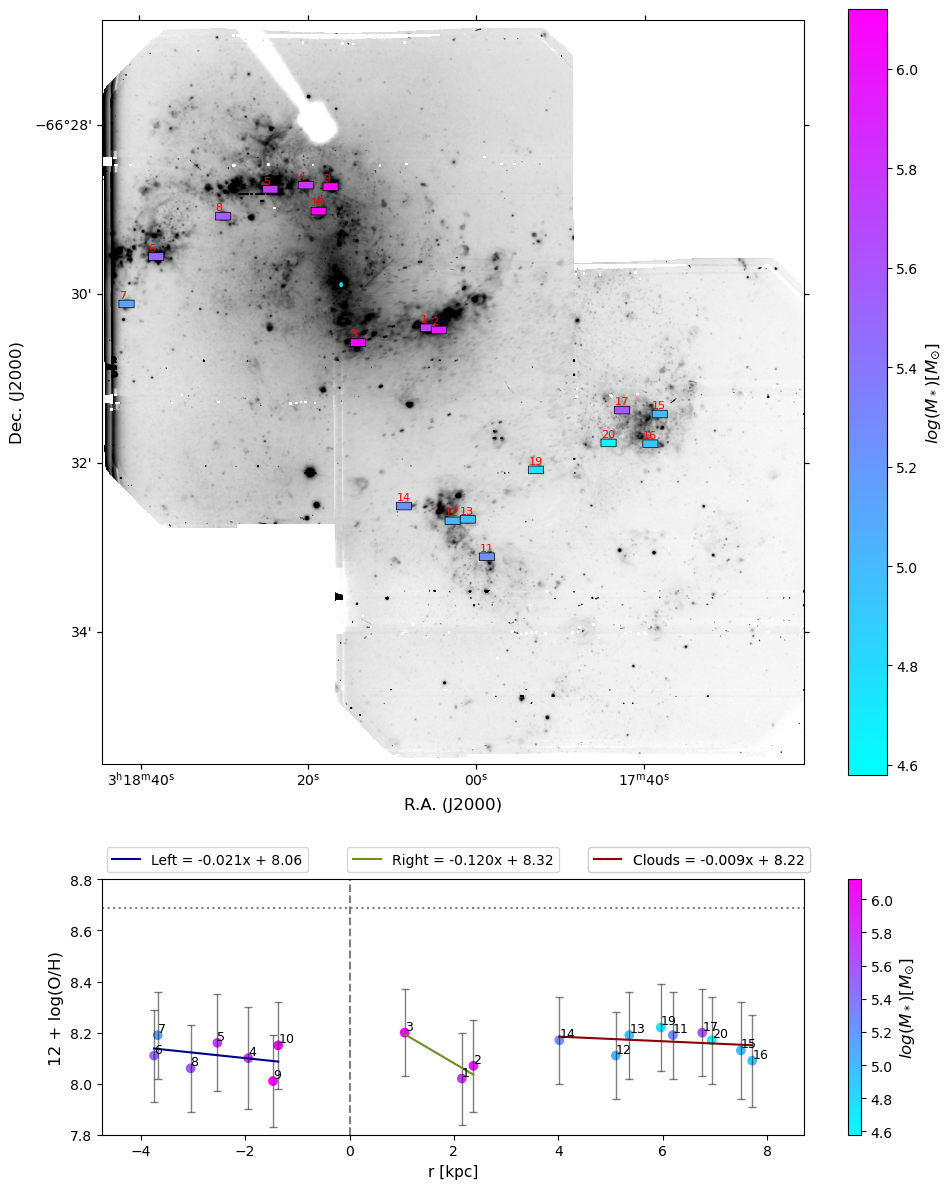

In [ ]:
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['signed_distance_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado para Lado Izquierdo
if len(group_left_galaxy) > 1:
    x1 = group_left_galaxy['signed_distance_kpc'].values
    y1 = group_left_galaxy['12_LOG_OH_N2'].values
    sigma_y1 = group_left_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights1 = 1 / sigma_y1
    coeffs1, cov1 = np.polyfit(x1, y1, deg=1, w=weights1, cov=True)
    m1, b1 = coeffs1
    m1_err = np.sqrt(cov1[0,0])
    b1_err = np.sqrt(cov1[1,1])
    y_pred1 = m1 * x1 + b1
    chi_squared1 = np.sum((y1 - y_pred1)**2 / sigma_y1**2)
    dof1 = len(x1) - 2
    reduced_chi_squared1 = chi_squared1 / dof1 if dof1 > 0 else np.nan
else:
    m1, b1, reduced_chi_squared1 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Galaxia (Derecho)
if len(group_right_galaxy) > 1:
    x2 = group_right_galaxy['signed_distance_kpc'].values
    y2 = group_right_galaxy['12_LOG_OH_N2'].values
    sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights2 = 1 / sigma_y2
    coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
    m2, b2 = coeffs2
    m2_err = np.sqrt(cov2[0,0])
    b2_err = np.sqrt(cov2[1,1])
    y_pred2 = m2 * x2 + b2
    chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
    dof2 = len(x2) - 2
    reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
else:
    m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
if len(group_clouds) > 1:
    x3 = group_clouds['signed_distance_kpc'].values
    y3 = group_clouds['12_LOG_OH_N2'].values
    sigma_y3 = group_clouds['12_LOG_OH_N2_TOTAL_ERR'].values
    weights3 = 1 / sigma_y3
    coeffs3, cov3 = np.polyfit(x3, y3, deg=1, w=weights3, cov=True)
    m3, b3 = coeffs3 
    m3_err = np.sqrt(cov3[0,0])
    b3_err = np.sqrt(cov3[1,1])
    y_pred3 = m3 * x3 + b3
    chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
    dof3 = len(x3) - 2
    reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
else:
    m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov1)
print("Lado Izquierdo (signed_distance_kpc < 0):")
print(f"Pendiente: {m1:.4f} ± {m1_err:.4f}" if not np.isnan(m1) else "Pendiente: N/A")
print(f"Intercepto: {b1:.4f} ± {b1_err:.4f}" if not np.isnan(b1) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared1:.2f}" if not np.isnan(reduced_chi_squared1) else "Chi-cuadrado red.: N/A")
print("\nGalaxia (Derecho, IDs 1-3, signed_distance_kpc >= 0):")
print(f"Pendiente: {m2:.4f} ± {m2_err:.4f}" if not np.isnan(m2) else "Pendiente: N/A")
print(f"Intercepto: {b2:.4f} ± {b2_err:.4f}" if not np.isnan(b2) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared2:.2f}" if not np.isnan(reduced_chi_squared2) else "Chi-cuadrado red.: N/A")
print("\nNubes (IDs 11-19):")
print(f"Pendiente: {m3:.4f} ± {m3_err:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
print(f"Intercepto: {b3:.4f} ± {b3_err:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    x_fit1 = np.linspace(np.min(x1), np.max(x1), 100)
    y_fit1 = m1 * x_fit1 + b1
    line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Left = {m1:.3f}x + {b1:.2f}")
#line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Left = {m1:.3f}x + {b1:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared1:.2f}")

if len(group_right_galaxy) > 1 and not np.isnan(m2):
    x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
    y_fit2 = m2 * x_fit2 + b2
    line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Right = {m2:.3f}x + {b2:.2f}")
    print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
    print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

if len(group_clouds) > 1 and not np.isnan(m3):
    x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
    y_fit3 = m3 * x_fit3 + b3
    line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea horizontal en y=8.69 solar abundances
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    legend1 = ax2.legend(handles=[line1], loc='lower center', bbox_to_anchor=(0.15, 1.0))   
    ax2.add_artist(legend1)
if len(group_right_galaxy) > 1 and not np.isnan(m2):
    legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax2.add_artist(legend2)
if len(group_clouds) > 1 and not np.isnan(m3):
    legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
    ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

In [ ]:
# Parámetro para las colorbars
color_param = '12_LOG_OH_N2'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Myr]',
    'ne': 'n$_e$ [cm$^{-3}$]',
}

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool


# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)


<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/2563302221.py:5: SyntaxWarning: invalid escape sequence '\o'
  'mass': '$log(M_*)[M_{\odot}]$',
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/2563302221.py:22: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[0.00068865 0.00176477]
 [0.00176477 0.00512275]]
Lado Izquierdo (signed_distance_kpc < 0):
Pendiente: -0.0215 ± 0.0262
Intercepto: 8.0571 ± 0.0716
Chi-cuadrado red.: 0.13

Galaxia (Derecho, IDs 1-3, signed_distance_kpc >= 0):
Pendiente: -0.1204 ± 0.0532
Intercepto: 8.3208 ± 0.1022
Chi-cuadrado red.: 0.09

Nubes (IDs 11-19):
Pendiente: -0.0091 ± 0.0134
Intercepto: 8.2206 ± 0.0832
Chi-cuadrado red.: 0.07
x_fit2 range: 1.0566975100962768 to 2.373826515813847
y_fit2 range: 8.035109332173883 to 8.193634781366113


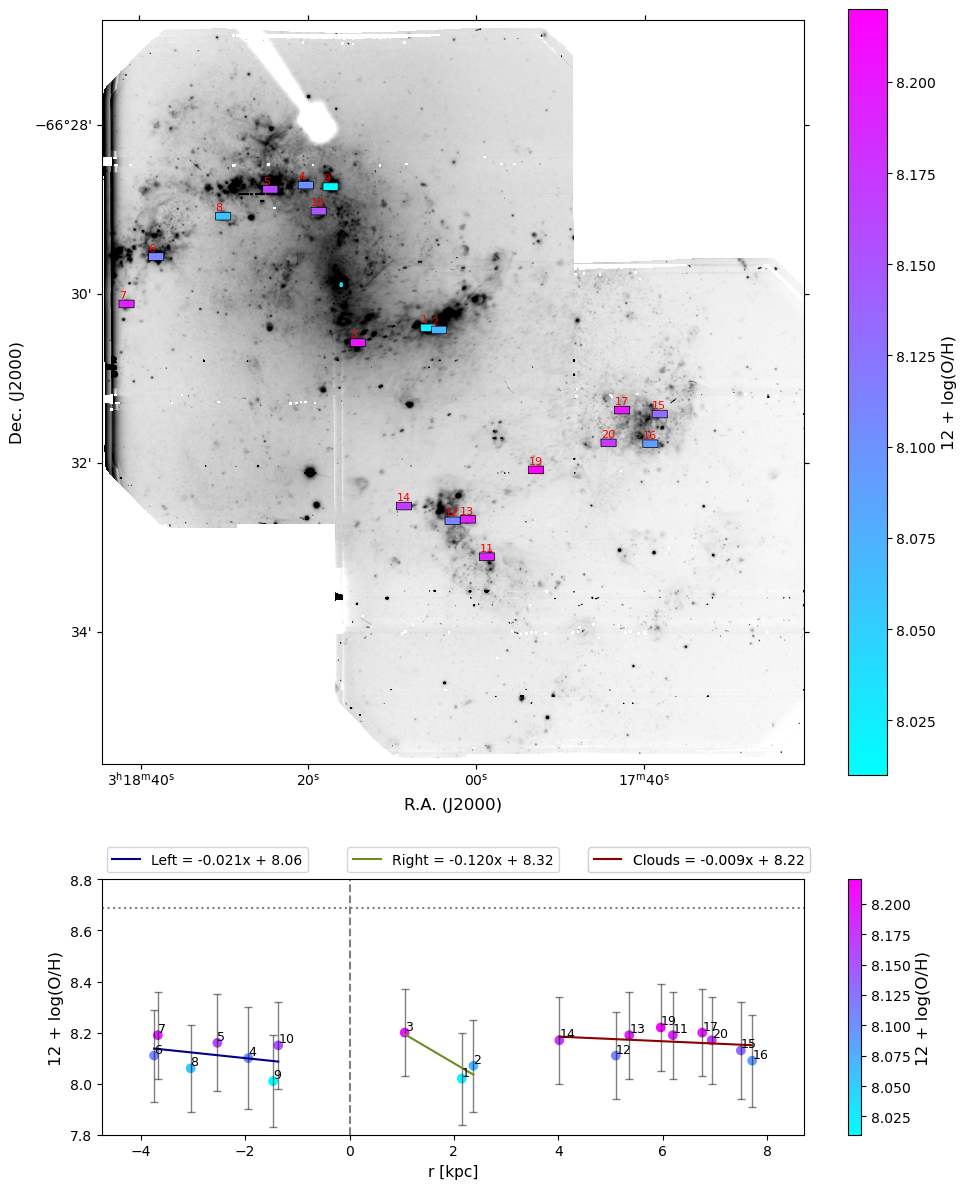

In [ ]:

fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['signed_distance_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado para Lado Izquierdo
if len(group_left_galaxy) > 1:
    x1 = group_left_galaxy['signed_distance_kpc'].values
    y1 = group_left_galaxy['12_LOG_OH_N2'].values
    sigma_y1 = group_left_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights1 = 1 / sigma_y1
    coeffs1, cov1 = np.polyfit(x1, y1, deg=1, w=weights1, cov=True)
    m1, b1 = coeffs1
    m1_err = np.sqrt(cov1[0,0])
    b1_err = np.sqrt(cov1[1,1])
    y_pred1 = m1 * x1 + b1
    chi_squared1 = np.sum((y1 - y_pred1)**2 / sigma_y1**2)
    dof1 = len(x1) - 2
    reduced_chi_squared1 = chi_squared1 / dof1 if dof1 > 0 else np.nan
else:
    m1, b1, reduced_chi_squared1 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Galaxia (Derecho)
if len(group_right_galaxy) > 1:
    x2 = group_right_galaxy['signed_distance_kpc'].values
    y2 = group_right_galaxy['12_LOG_OH_N2'].values
    sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights2 = 1 / sigma_y2
    coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
    m2, b2 = coeffs2
    m2_err = np.sqrt(cov2[0,0])
    b2_err = np.sqrt(cov2[1,1])
    y_pred2 = m2 * x2 + b2
    chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
    dof2 = len(x2) - 2
    reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
else:
    m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
if len(group_clouds) > 1:
    x3 = group_clouds['signed_distance_kpc'].values
    y3 = group_clouds['12_LOG_OH_N2'].values
    sigma_y3 = group_clouds['12_LOG_OH_N2_TOTAL_ERR'].values
    weights3 = 1 / sigma_y3
    coeffs3, cov3 = np.polyfit(x3, y3, deg=1, w=weights3, cov=True)
    m3, b3 = coeffs3 
    m3_err = np.sqrt(cov3[0,0])
    b3_err = np.sqrt(cov3[1,1])
    y_pred3 = m3 * x3 + b3
    chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
    dof3 = len(x3) - 2
    reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
else:
    m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov1)
print("Lado Izquierdo (signed_distance_kpc < 0):")
print(f"Pendiente: {m1:.4f} ± {m1_err:.4f}" if not np.isnan(m1) else "Pendiente: N/A")
print(f"Intercepto: {b1:.4f} ± {b1_err:.4f}" if not np.isnan(b1) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared1:.2f}" if not np.isnan(reduced_chi_squared1) else "Chi-cuadrado red.: N/A")
print("\nGalaxia (Derecho, IDs 1-3, signed_distance_kpc >= 0):")
print(f"Pendiente: {m2:.4f} ± {m2_err:.4f}" if not np.isnan(m2) else "Pendiente: N/A")
print(f"Intercepto: {b2:.4f} ± {b2_err:.4f}" if not np.isnan(b2) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared2:.2f}" if not np.isnan(reduced_chi_squared2) else "Chi-cuadrado red.: N/A")
print("\nNubes (IDs 11-19):")
print(f"Pendiente: {m3:.4f} ± {m3_err:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
print(f"Intercepto: {b3:.4f} ± {b3_err:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    x_fit1 = np.linspace(np.min(x1), np.max(x1), 100)
    y_fit1 = m1 * x_fit1 + b1
    line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Left = {m1:.3f}x + {b1:.2f}")
#line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Left = {m1:.3f}x + {b1:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared1:.2f}")

if len(group_right_galaxy) > 1 and not np.isnan(m2):
    x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
    y_fit2 = m2 * x_fit2 + b2
    line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Right = {m2:.3f}x + {b2:.2f}")
    print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
    print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

if len(group_clouds) > 1 and not np.isnan(m3):
    x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
    y_fit3 = m3 * x_fit3 + b3
    line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea horizontal en y=8.69 solar abundances
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    legend1 = ax2.legend(handles=[line1], loc='lower center', bbox_to_anchor=(0.15, 1.0))   
    ax2.add_artist(legend1)
if len(group_right_galaxy) > 1 and not np.isnan(m2):
    legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax2.add_artist(legend2)
if len(group_clouds) > 1 and not np.isnan(m3):
    legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
    ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

In [ ]:
# Parámetro para las colorbars
color_param = 'age'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Myr]',
    'ne': 'n$_e$ [cm$^{-3}$]',
}

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool


# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)


<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/2030323784.py:5: SyntaxWarning: invalid escape sequence '\o'
  'mass': '$log(M_*)[M_{\odot}]$',
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/2030323784.py:22: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[0.00068865 0.00176477]
 [0.00176477 0.00512275]]
Lado Izquierdo (signed_distance_kpc < 0):
Pendiente: -0.0215 ± 0.0262
Intercepto: 8.0571 ± 0.0716
Chi-cuadrado red.: 0.13

Galaxia (Derecho, IDs 1-3, signed_distance_kpc >= 0):
Pendiente: -0.1204 ± 0.0532
Intercepto: 8.3208 ± 0.1022
Chi-cuadrado red.: 0.09

Nubes (IDs 11-19):
Pendiente: -0.0091 ± 0.0134
Intercepto: 8.2206 ± 0.0832
Chi-cuadrado red.: 0.07
x_fit2 range: 1.0566975100962768 to 2.373826515813847
y_fit2 range: 8.035109332173883 to 8.193634781366113


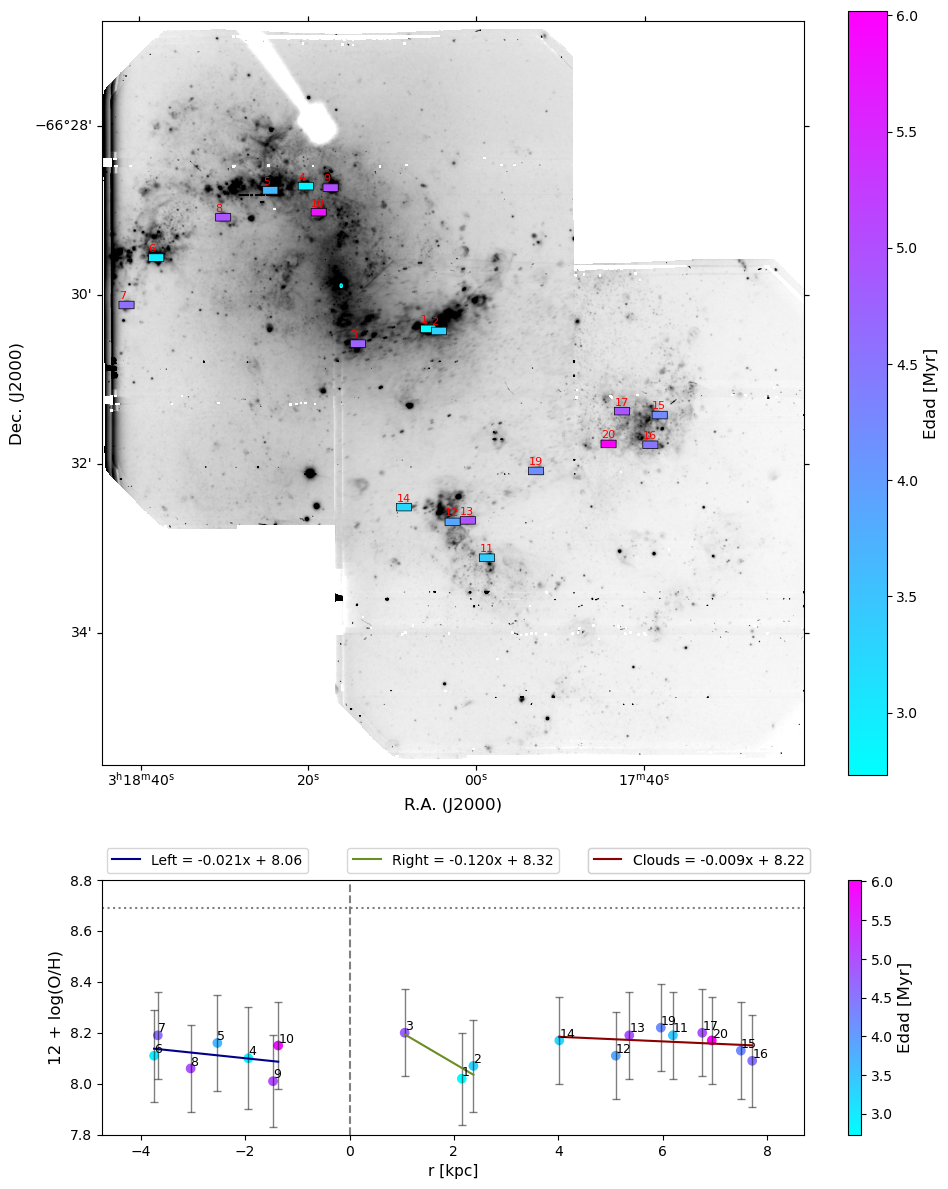

In [ ]:

fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['signed_distance_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado para Lado Izquierdo
if len(group_left_galaxy) > 1:
    x1 = group_left_galaxy['signed_distance_kpc'].values
    y1 = group_left_galaxy['12_LOG_OH_N2'].values
    sigma_y1 = group_left_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights1 = 1 / sigma_y1
    coeffs1, cov1 = np.polyfit(x1, y1, deg=1, w=weights1, cov=True)
    m1, b1 = coeffs1
    m1_err = np.sqrt(cov1[0,0])
    b1_err = np.sqrt(cov1[1,1])
    y_pred1 = m1 * x1 + b1
    chi_squared1 = np.sum((y1 - y_pred1)**2 / sigma_y1**2)
    dof1 = len(x1) - 2
    reduced_chi_squared1 = chi_squared1 / dof1 if dof1 > 0 else np.nan
else:
    m1, b1, reduced_chi_squared1 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Galaxia (Derecho)
if len(group_right_galaxy) > 1:
    x2 = group_right_galaxy['signed_distance_kpc'].values
    y2 = group_right_galaxy['12_LOG_OH_N2'].values
    sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights2 = 1 / sigma_y2
    coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
    m2, b2 = coeffs2
    m2_err = np.sqrt(cov2[0,0])
    b2_err = np.sqrt(cov2[1,1])
    y_pred2 = m2 * x2 + b2
    chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
    dof2 = len(x2) - 2
    reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
else:
    m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
if len(group_clouds) > 1:
    x3 = group_clouds['signed_distance_kpc'].values
    y3 = group_clouds['12_LOG_OH_N2'].values
    sigma_y3 = group_clouds['12_LOG_OH_N2_TOTAL_ERR'].values
    weights3 = 1 / sigma_y3
    coeffs3, cov3 = np.polyfit(x3, y3, deg=1, w=weights3, cov=True)
    m3, b3 = coeffs3 
    m3_err = np.sqrt(cov3[0,0])
    b3_err = np.sqrt(cov3[1,1])
    y_pred3 = m3 * x3 + b3
    chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
    dof3 = len(x3) - 2
    reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
else:
    m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov1)
print("Lado Izquierdo (signed_distance_kpc < 0):")
print(f"Pendiente: {m1:.4f} ± {m1_err:.4f}" if not np.isnan(m1) else "Pendiente: N/A")
print(f"Intercepto: {b1:.4f} ± {b1_err:.4f}" if not np.isnan(b1) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared1:.2f}" if not np.isnan(reduced_chi_squared1) else "Chi-cuadrado red.: N/A")
print("\nGalaxia (Derecho, IDs 1-3, signed_distance_kpc >= 0):")
print(f"Pendiente: {m2:.4f} ± {m2_err:.4f}" if not np.isnan(m2) else "Pendiente: N/A")
print(f"Intercepto: {b2:.4f} ± {b2_err:.4f}" if not np.isnan(b2) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared2:.2f}" if not np.isnan(reduced_chi_squared2) else "Chi-cuadrado red.: N/A")
print("\nNubes (IDs 11-19):")
print(f"Pendiente: {m3:.4f} ± {m3_err:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
print(f"Intercepto: {b3:.4f} ± {b3_err:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    x_fit1 = np.linspace(np.min(x1), np.max(x1), 100)
    y_fit1 = m1 * x_fit1 + b1
    line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Left = {m1:.3f}x + {b1:.2f}")
#line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Left = {m1:.3f}x + {b1:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared1:.2f}")

if len(group_right_galaxy) > 1 and not np.isnan(m2):
    x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
    y_fit2 = m2 * x_fit2 + b2
    line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Right = {m2:.3f}x + {b2:.2f}")
    print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
    print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

if len(group_clouds) > 1 and not np.isnan(m3):
    x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
    y_fit3 = m3 * x_fit3 + b3
    line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea horizontal en y=8.69 solar abundances
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    legend1 = ax2.legend(handles=[line1], loc='lower center', bbox_to_anchor=(0.15, 1.0))   
    ax2.add_artist(legend1)
if len(group_right_galaxy) > 1 and not np.isnan(m2):
    legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax2.add_artist(legend2)
if len(group_clouds) > 1 and not np.isnan(m3):
    legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
    ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

In [ ]:
# Parámetro para las colorbars
color_param = 'n_e'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Myr]',
    'n_e': 'n$_e$ [cm$^{-3}$]',
}

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool


# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)


<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/3305297570.py:5: SyntaxWarning: invalid escape sequence '\o'
  'mass': '$log(M_*)[M_{\odot}]$',


/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1019/3305297570.py:22: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[0.00068865 0.00176477]
 [0.00176477 0.00512275]]
Lado Izquierdo (signed_distance_kpc < 0):
Pendiente: -0.0215 ± 0.0262
Intercepto: 8.0571 ± 0.0716
Chi-cuadrado red.: 0.13

Galaxia (Derecho, IDs 1-3, signed_distance_kpc >= 0):
Pendiente: -0.1204 ± 0.0532
Intercepto: 8.3208 ± 0.1022
Chi-cuadrado red.: 0.09

Nubes (IDs 11-19):
Pendiente: -0.0091 ± 0.0134
Intercepto: 8.2206 ± 0.0832
Chi-cuadrado red.: 0.07
x_fit2 range: 1.0566975100962768 to 2.373826515813847
y_fit2 range: 8.035109332173883 to 8.193634781366113


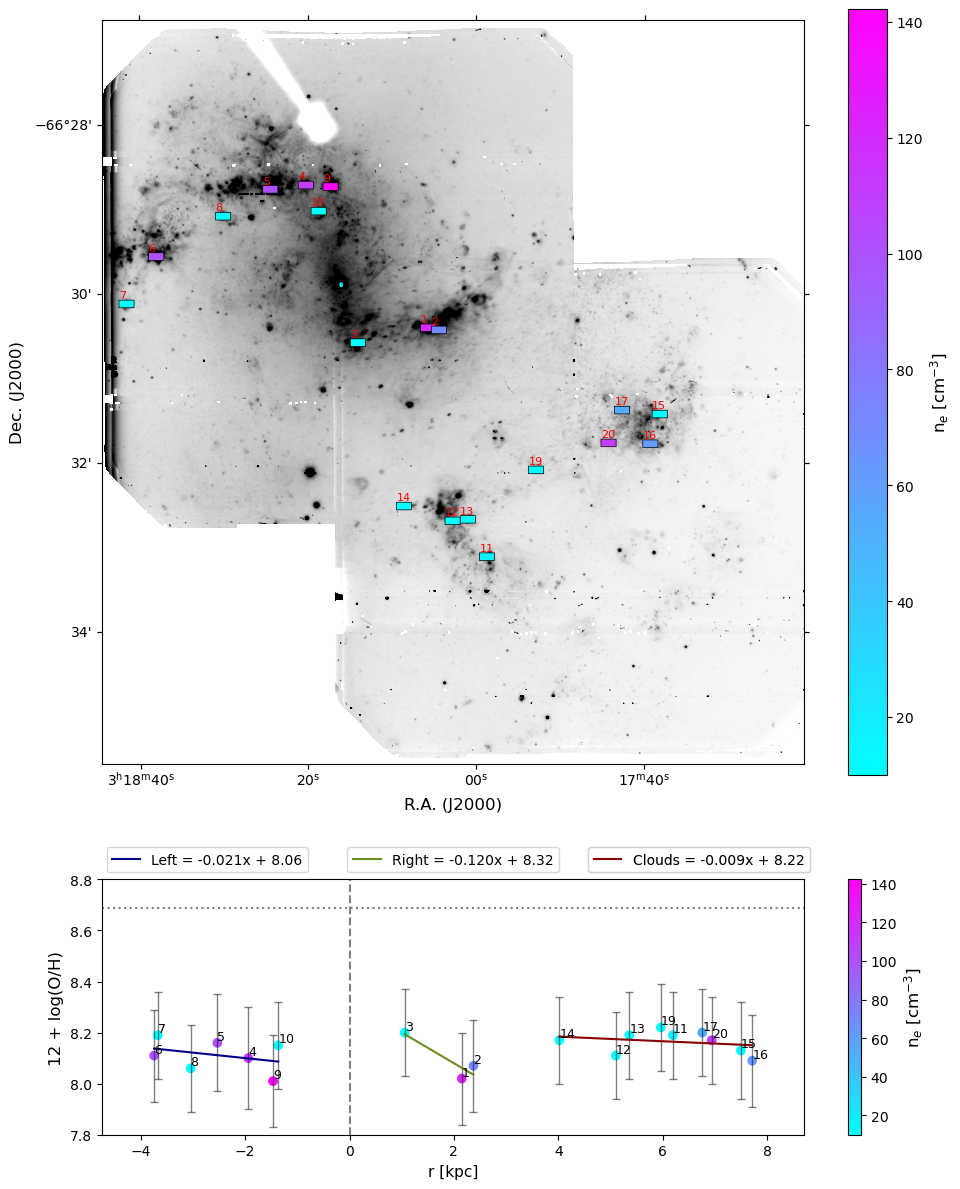

In [ ]:

fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['signed_distance_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado para Lado Izquierdo
if len(group_left_galaxy) > 1:
    x1 = group_left_galaxy['signed_distance_kpc'].values
    y1 = group_left_galaxy['12_LOG_OH_N2'].values
    sigma_y1 = group_left_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights1 = 1 / sigma_y1
    coeffs1, cov1 = np.polyfit(x1, y1, deg=1, w=weights1, cov=True)
    m1, b1 = coeffs1
    m1_err = np.sqrt(cov1[0,0])
    b1_err = np.sqrt(cov1[1,1])
    y_pred1 = m1 * x1 + b1
    chi_squared1 = np.sum((y1 - y_pred1)**2 / sigma_y1**2)
    dof1 = len(x1) - 2
    reduced_chi_squared1 = chi_squared1 / dof1 if dof1 > 0 else np.nan
else:
    m1, b1, reduced_chi_squared1 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Galaxia (Derecho)
if len(group_right_galaxy) > 1:
    x2 = group_right_galaxy['signed_distance_kpc'].values
    y2 = group_right_galaxy['12_LOG_OH_N2'].values
    sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
    weights2 = 1 / sigma_y2
    coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
    m2, b2 = coeffs2
    m2_err = np.sqrt(cov2[0,0])
    b2_err = np.sqrt(cov2[1,1])
    y_pred2 = m2 * x2 + b2
    chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
    dof2 = len(x2) - 2
    reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
else:
    m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
if len(group_clouds) > 1:
    x3 = group_clouds['signed_distance_kpc'].values
    y3 = group_clouds['12_LOG_OH_N2'].values
    sigma_y3 = group_clouds['12_LOG_OH_N2_TOTAL_ERR'].values
    weights3 = 1 / sigma_y3
    coeffs3, cov3 = np.polyfit(x3, y3, deg=1, w=weights3, cov=True)
    m3, b3 = coeffs3 
    m3_err = np.sqrt(cov3[0,0])
    b3_err = np.sqrt(cov3[1,1])
    y_pred3 = m3 * x3 + b3
    chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
    dof3 = len(x3) - 2
    reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
else:
    m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov1)
print("Lado Izquierdo (signed_distance_kpc < 0):")
print(f"Pendiente: {m1:.4f} ± {m1_err:.4f}" if not np.isnan(m1) else "Pendiente: N/A")
print(f"Intercepto: {b1:.4f} ± {b1_err:.4f}" if not np.isnan(b1) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared1:.2f}" if not np.isnan(reduced_chi_squared1) else "Chi-cuadrado red.: N/A")
print("\nGalaxia (Derecho, IDs 1-3, signed_distance_kpc >= 0):")
print(f"Pendiente: {m2:.4f} ± {m2_err:.4f}" if not np.isnan(m2) else "Pendiente: N/A")
print(f"Intercepto: {b2:.4f} ± {b2_err:.4f}" if not np.isnan(b2) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared2:.2f}" if not np.isnan(reduced_chi_squared2) else "Chi-cuadrado red.: N/A")
print("\nNubes (IDs 11-19):")
print(f"Pendiente: {m3:.4f} ± {m3_err:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
print(f"Intercepto: {b3:.4f} ± {b3_err:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    x_fit1 = np.linspace(np.min(x1), np.max(x1), 100)
    y_fit1 = m1 * x_fit1 + b1
    line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Left = {m1:.3f}x + {b1:.2f}")
#line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Left = {m1:.3f}x + {b1:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared1:.2f}")

if len(group_right_galaxy) > 1 and not np.isnan(m2):
    x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
    y_fit2 = m2 * x_fit2 + b2
    line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Right = {m2:.3f}x + {b2:.2f}")
    print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
    print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

if len(group_clouds) > 1 and not np.isnan(m3):
    x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
    y_fit3 = m3 * x_fit3 + b3
    line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea horizontal en y=8.69 solar abundances
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas
if len(group_left_galaxy) > 1 and not np.isnan(m1):
    legend1 = ax2.legend(handles=[line1], loc='lower center', bbox_to_anchor=(0.15, 1.0))   
    ax2.add_artist(legend1)
if len(group_right_galaxy) > 1 and not np.isnan(m2):
    legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax2.add_artist(legend2)
if len(group_clouds) > 1 and not np.isnan(m3):
    legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
    ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()